# AM 207 - Deep Ensembles: A Loss Landscape

### Blobs Toy Dataset Experimentation Notebook

#### Project Team: Emre Erdem, Carter Nakamoto, Anita Mahinpei

#### Content

- Toy dataset creation
- Initial neural network training
- Deep Ensemble with random initialization
- Bayesian Dropout Subspace sampling
- Bayesian Random Subspace sampling
- HMC
- ADVI

In [21]:
import tensorflow as tf
#from keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
#from keras.layers import Conv2D, MaxPooling2D
#from keras import backend as K

import numpy as np
import pandas as pd
import pymc3 as pm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import scale
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns 

import theano
import theano.tensor as T
from warnings import filterwarnings
print(tf.__version__)

2.3.1


In [22]:
%config InlineBackend.figure_format = 'retina'
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
floatX = theano.config.floatX
filterwarnings('ignore')
sns.set_style('white')

## Toy dataset creation

In [23]:
TOY_DATA_TYPE = "blobs"

# Generate a toy dataset for classification
def generate_toy_data():
    if TOY_DATA_TYPE == "moons":
        return make_moons(noise=0.2, random_state=0, n_samples=2000)
    elif TOY_DATA_TYPE == "circles":
        return make_circles(noise=0.1, random_state=0, n_samples=2000, factor=0.5)
    elif TOY_DATA_TYPE == "blobs":
        return make_blobs(cluster_std=0.8, random_state=0, n_samples=2000, centers=np.array([[-1,-1], [1, 1]]))

X, Y = generate_toy_data()
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

# Define test data points
def generate_test_points(): 
    if TOY_DATA_TYPE == "moons":
        return [(0.5, -0.4), (0.5, 0.8), (0.5, 0.25), (-0.8, 0.5), (1.7, -0.3), (-1.5, -3), 
                (-1.5, 3), (3, -3), (3, 3)]
    elif TOY_DATA_TYPE == "circles":
        return [(0, 0), (0, 2), (0, -2), (2, 0), (-2, 0), (-1, 0), (-0.75, 0), (-0.5, 0),
               (1, 0), (0.75, 0), (0.5, 0), (0, 1), (0, 0.75), (0, 0.5), (0, -1), (0, -0.75), 
                (0, -0.5)]
    elif TOY_DATA_TYPE == "blobs":
        return [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]

test_points = generate_test_points()

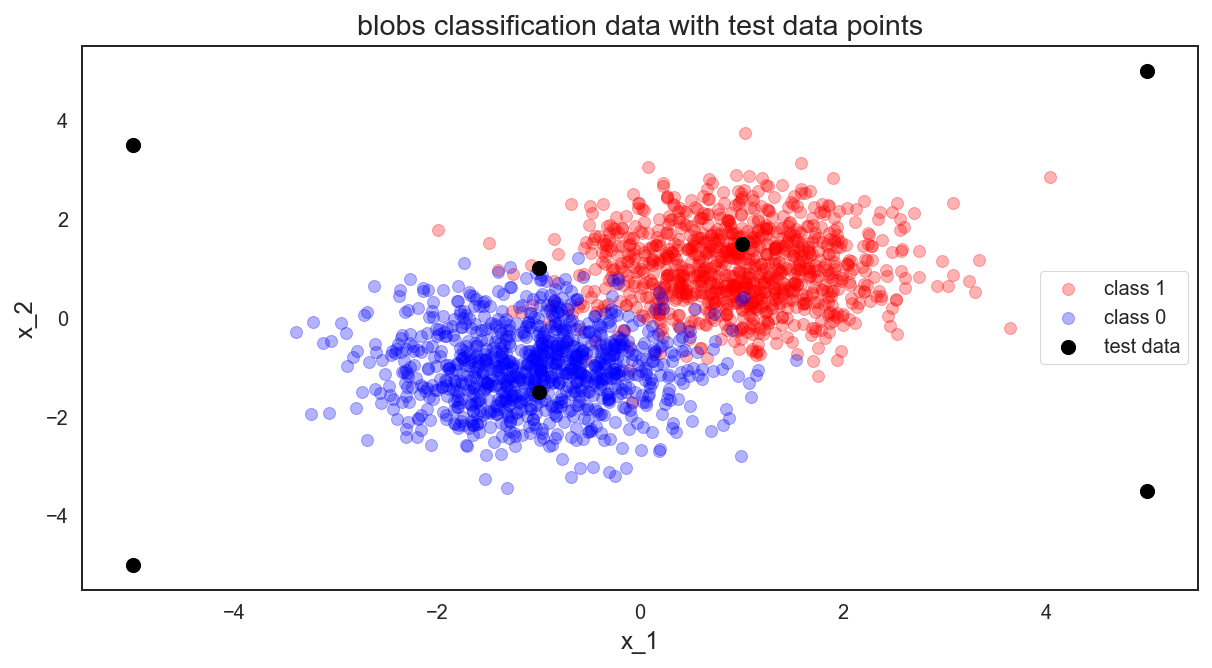

In [24]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('{} classification data with test data points'.format(TOY_DATA_TYPE))
ax.legend(loc='best')
plt.savefig("{}_data_plot.png".format(TOY_DATA_TYPE))

## Initial Neural Network Training

In [25]:
batch_size = 256
num_classes = 2
epochs = 1000

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

x_train shape: (1000, 2)
x_test shape: (1000, 2)


In [27]:
Y_train.shape

(1000,)

In [28]:
input_shape = X_train.shape[1]
input_shape

2

In [29]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor)
    else:
        return input_tensor

def get_model(mc=False, p=0.5, act="tanh"):
    if TOY_DATA_TYPE == "blobs" or TOY_DATA_TYPE == "moons" or TOY_DATA_TYPE == "circles":
        inp = Input(shape=(input_shape,))
        x = Dense(64, activation=act)(inp)
        x = get_dropout(x, p=p, mc=mc)
        x = Dense(8, activation=act)(x)
        x = get_dropout(x, p=p, mc=mc)
        out = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inp, outputs=out)

        model.compile(loss=tf.keras.losses.binary_crossentropy,
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])
        return model

In [30]:
base_model = get_model(mc=False)


In [31]:
base_model.summary()

Model: "functional_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_87 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_88 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 9         
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________


In [32]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=20)
history = base_model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[es],
                    validation_data=(X_test, Y_test))

Epoch 1/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.6736 - accuracy: 0.6120 - val_loss: 0.5994 - val_accuracy: 0.7770
Epoch 2/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.5753 - accuracy: 0.8120 - val_loss: 0.5077 - val_accuracy: 0.8860
Epoch 3/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.4924 - accuracy: 0.8910 - val_loss: 0.4326 - val_accuracy: 0.9240
Epoch 4/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.4253 - accuracy: 0.9240 - val_loss: 0.3717 - val_accuracy: 0.9530
Epoch 5/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.3706 - accuracy: 0.9420 - val_loss: 0.3229 - val_accuracy: 0.9610
Epoch 6/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.3263 - accuracy: 0.9510 - val_loss: 0.2839 - val_accuracy: 0.9610
Epoch 7/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2909 - accuracy: 0.9560 - val_loss: 0.2527 - val_accuracy: 0.9680
Epoch 8/1000
4/4 [

Epoch 59/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1043 - accuracy: 0.9630 - val_loss: 0.0883 - val_accuracy: 0.9730
Epoch 60/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1041 - accuracy: 0.9630 - val_loss: 0.0882 - val_accuracy: 0.9730
Epoch 61/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1040 - accuracy: 0.9630 - val_loss: 0.0881 - val_accuracy: 0.9730
Epoch 62/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1039 - accuracy: 0.9630 - val_loss: 0.0880 - val_accuracy: 0.9730
Epoch 63/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1037 - accuracy: 0.9630 - val_loss: 0.0879 - val_accuracy: 0.9730
Epoch 64/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1036 - accuracy: 0.9630 - val_loss: 0.0878 - val_accuracy: 0.9730
Epoch 65/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1035 - accuracy: 0.9630 - val_loss: 0.0878 - val_accuracy: 0.9730
Epoch 66/1000

Epoch 117/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1017 - accuracy: 0.9630 - val_loss: 0.0864 - val_accuracy: 0.9710
Epoch 118/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1017 - accuracy: 0.9630 - val_loss: 0.0864 - val_accuracy: 0.9700
Epoch 119/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1017 - accuracy: 0.9630 - val_loss: 0.0864 - val_accuracy: 0.9710
Epoch 120/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1017 - accuracy: 0.9630 - val_loss: 0.0863 - val_accuracy: 0.9720
Epoch 121/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1017 - accuracy: 0.9630 - val_loss: 0.0862 - val_accuracy: 0.9730
Epoch 122/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1017 - accuracy: 0.9620 - val_loss: 0.0863 - val_accuracy: 0.9710
Epoch 123/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1016 - accuracy: 0.9630 - val_loss: 0.0863 - val_accuracy: 0.9710
Epoch 

4/4 [==============================] - 0s 6ms/step - loss: 0.1012 - accuracy: 0.9620 - val_loss: 0.0855 - val_accuracy: 0.9730
Epoch 175/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1012 - accuracy: 0.9630 - val_loss: 0.0855 - val_accuracy: 0.9730
Epoch 176/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1012 - accuracy: 0.9630 - val_loss: 0.0855 - val_accuracy: 0.9730
Epoch 177/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1012 - accuracy: 0.9630 - val_loss: 0.0855 - val_accuracy: 0.9730
Epoch 178/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1011 - accuracy: 0.9630 - val_loss: 0.0855 - val_accuracy: 0.9730
Epoch 179/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1012 - accuracy: 0.9630 - val_loss: 0.0855 - val_accuracy: 0.9720
Epoch 180/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1011 - accuracy: 0.9620 - val_loss: 0.0855 - val_accuracy: 0.9720
Epoch 181/1000
4/4 [=

4/4 [==============================] - 0s 5ms/step - loss: 0.1007 - accuracy: 0.9620 - val_loss: 0.0848 - val_accuracy: 0.9720
Epoch 232/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1007 - accuracy: 0.9620 - val_loss: 0.0848 - val_accuracy: 0.9720
Epoch 233/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1007 - accuracy: 0.9630 - val_loss: 0.0848 - val_accuracy: 0.9720
Epoch 234/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1007 - accuracy: 0.9630 - val_loss: 0.0848 - val_accuracy: 0.9720
Epoch 235/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1007 - accuracy: 0.9630 - val_loss: 0.0848 - val_accuracy: 0.9720
Epoch 236/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1007 - accuracy: 0.9630 - val_loss: 0.0847 - val_accuracy: 0.9730
Epoch 237/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1007 - accuracy: 0.9630 - val_loss: 0.0847 - val_accuracy: 0.9730
Epoch 238/1000
4/4 [=

Epoch 289/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1003 - accuracy: 0.9630 - val_loss: 0.0841 - val_accuracy: 0.9730
Epoch 290/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1003 - accuracy: 0.9620 - val_loss: 0.0841 - val_accuracy: 0.9720
Epoch 291/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1003 - accuracy: 0.9620 - val_loss: 0.0841 - val_accuracy: 0.9730
Epoch 292/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1003 - accuracy: 0.9630 - val_loss: 0.0841 - val_accuracy: 0.9730
Epoch 293/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1003 - accuracy: 0.9630 - val_loss: 0.0840 - val_accuracy: 0.9730
Epoch 294/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1003 - accuracy: 0.9630 - val_loss: 0.0840 - val_accuracy: 0.9730
Epoch 295/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1003 - accuracy: 0.9630 - val_loss: 0.0840 - val_accuracy: 0.9730
Epoch 

4/4 [==============================] - 0s 6ms/step - loss: 0.1000 - accuracy: 0.9630 - val_loss: 0.0835 - val_accuracy: 0.9730
Epoch 347/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1000 - accuracy: 0.9630 - val_loss: 0.0835 - val_accuracy: 0.9730
Epoch 348/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1000 - accuracy: 0.9640 - val_loss: 0.0834 - val_accuracy: 0.9730
Epoch 349/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1000 - accuracy: 0.9630 - val_loss: 0.0835 - val_accuracy: 0.9730
Epoch 350/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.0999 - accuracy: 0.9630 - val_loss: 0.0835 - val_accuracy: 0.9730
Epoch 351/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.0999 - accuracy: 0.9630 - val_loss: 0.0835 - val_accuracy: 0.9730
Epoch 352/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1000 - accuracy: 0.9630 - val_loss: 0.0835 - val_accuracy: 0.9720
Epoch 353/1000
4/4 [=

Epoch 404/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.0997 - accuracy: 0.9620 - val_loss: 0.0830 - val_accuracy: 0.9730
Epoch 405/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.0997 - accuracy: 0.9630 - val_loss: 0.0830 - val_accuracy: 0.9730
Epoch 406/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.0998 - accuracy: 0.9640 - val_loss: 0.0830 - val_accuracy: 0.9720
Epoch 407/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.0997 - accuracy: 0.9640 - val_loss: 0.0829 - val_accuracy: 0.9730
Epoch 408/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.0997 - accuracy: 0.9640 - val_loss: 0.0829 - val_accuracy: 0.9730
Epoch 409/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.0997 - accuracy: 0.9650 - val_loss: 0.0829 - val_accuracy: 0.9730
Epoch 410/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0997 - accuracy: 0.9650 - val_loss: 0.0829 - val_accuracy: 0.9730
Epoch 

4/4 [==============================] - 0s 10ms/step - loss: 0.0996 - accuracy: 0.9640 - val_loss: 0.0825 - val_accuracy: 0.9730
Epoch 462/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.0994 - accuracy: 0.9650 - val_loss: 0.0825 - val_accuracy: 0.9730
Epoch 463/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.0994 - accuracy: 0.9640 - val_loss: 0.0826 - val_accuracy: 0.9720
Epoch 464/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.0994 - accuracy: 0.9640 - val_loss: 0.0827 - val_accuracy: 0.9720
Epoch 465/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.0996 - accuracy: 0.9640 - val_loss: 0.0826 - val_accuracy: 0.9720
Epoch 466/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.0995 - accuracy: 0.9640 - val_loss: 0.0827 - val_accuracy: 0.9720
Epoch 467/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.0995 - accuracy: 0.9630 - val_loss: 0.0827 - val_accuracy: 0.9720
Epoch 468/1000
4/4 

Epoch 519/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0991 - accuracy: 0.9650 - val_loss: 0.0824 - val_accuracy: 0.9720
Epoch 520/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0991 - accuracy: 0.9630 - val_loss: 0.0824 - val_accuracy: 0.9720
Epoch 521/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0991 - accuracy: 0.9640 - val_loss: 0.0824 - val_accuracy: 0.9720
Epoch 522/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0991 - accuracy: 0.9640 - val_loss: 0.0823 - val_accuracy: 0.9720
Epoch 523/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0991 - accuracy: 0.9640 - val_loss: 0.0823 - val_accuracy: 0.9720
Epoch 524/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0991 - accuracy: 0.9630 - val_loss: 0.0823 - val_accuracy: 0.9730
Epoch 525/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0991 - accuracy: 0.9640 - val_loss: 0.0823 - val_accuracy: 0.9730
Epoch 

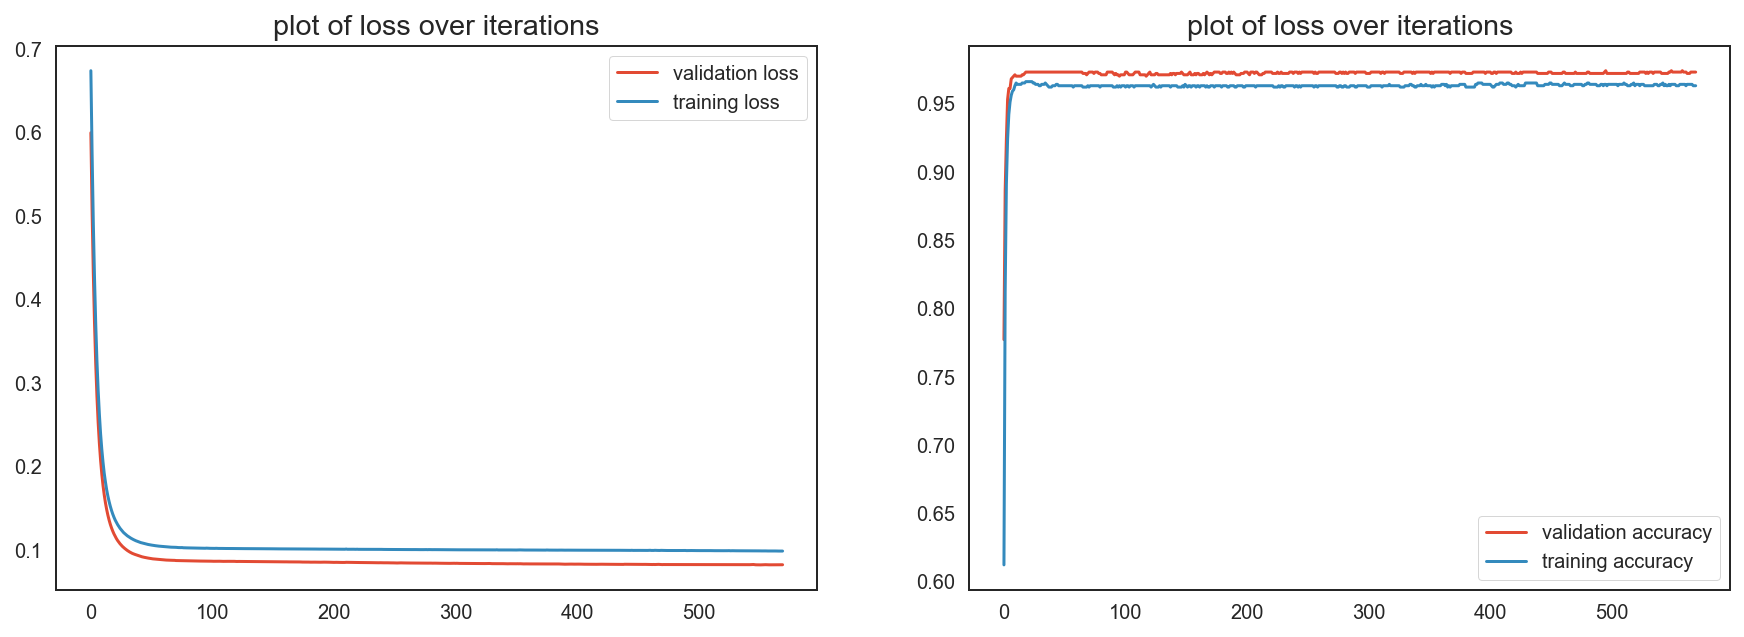

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(history.history["val_loss"], label="validation loss")
ax[0].plot(history.history["loss"], label="training loss")
ax[0].set_title("plot of loss over iterations")
ax[0].legend()
ax[1].plot(history.history["val_accuracy"], label="validation accuracy")
ax[1].plot(history.history["accuracy"], label="training accuracy")
ax[1].set_title("plot of loss over iterations")
ax[1].legend()
plt.show()

In [34]:
weights = base_model.get_weights()
base_model.save_weights('initial_model_weights.h5')

In [35]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [36]:
pred2 = base_model.predict(grid_2d)[:,0].flatten()
pred = base_model.predict(X_test)[:,0].flatten() > 0.5

Text(0, 0.5, 'posterior predictive mean probability of class label = 0')

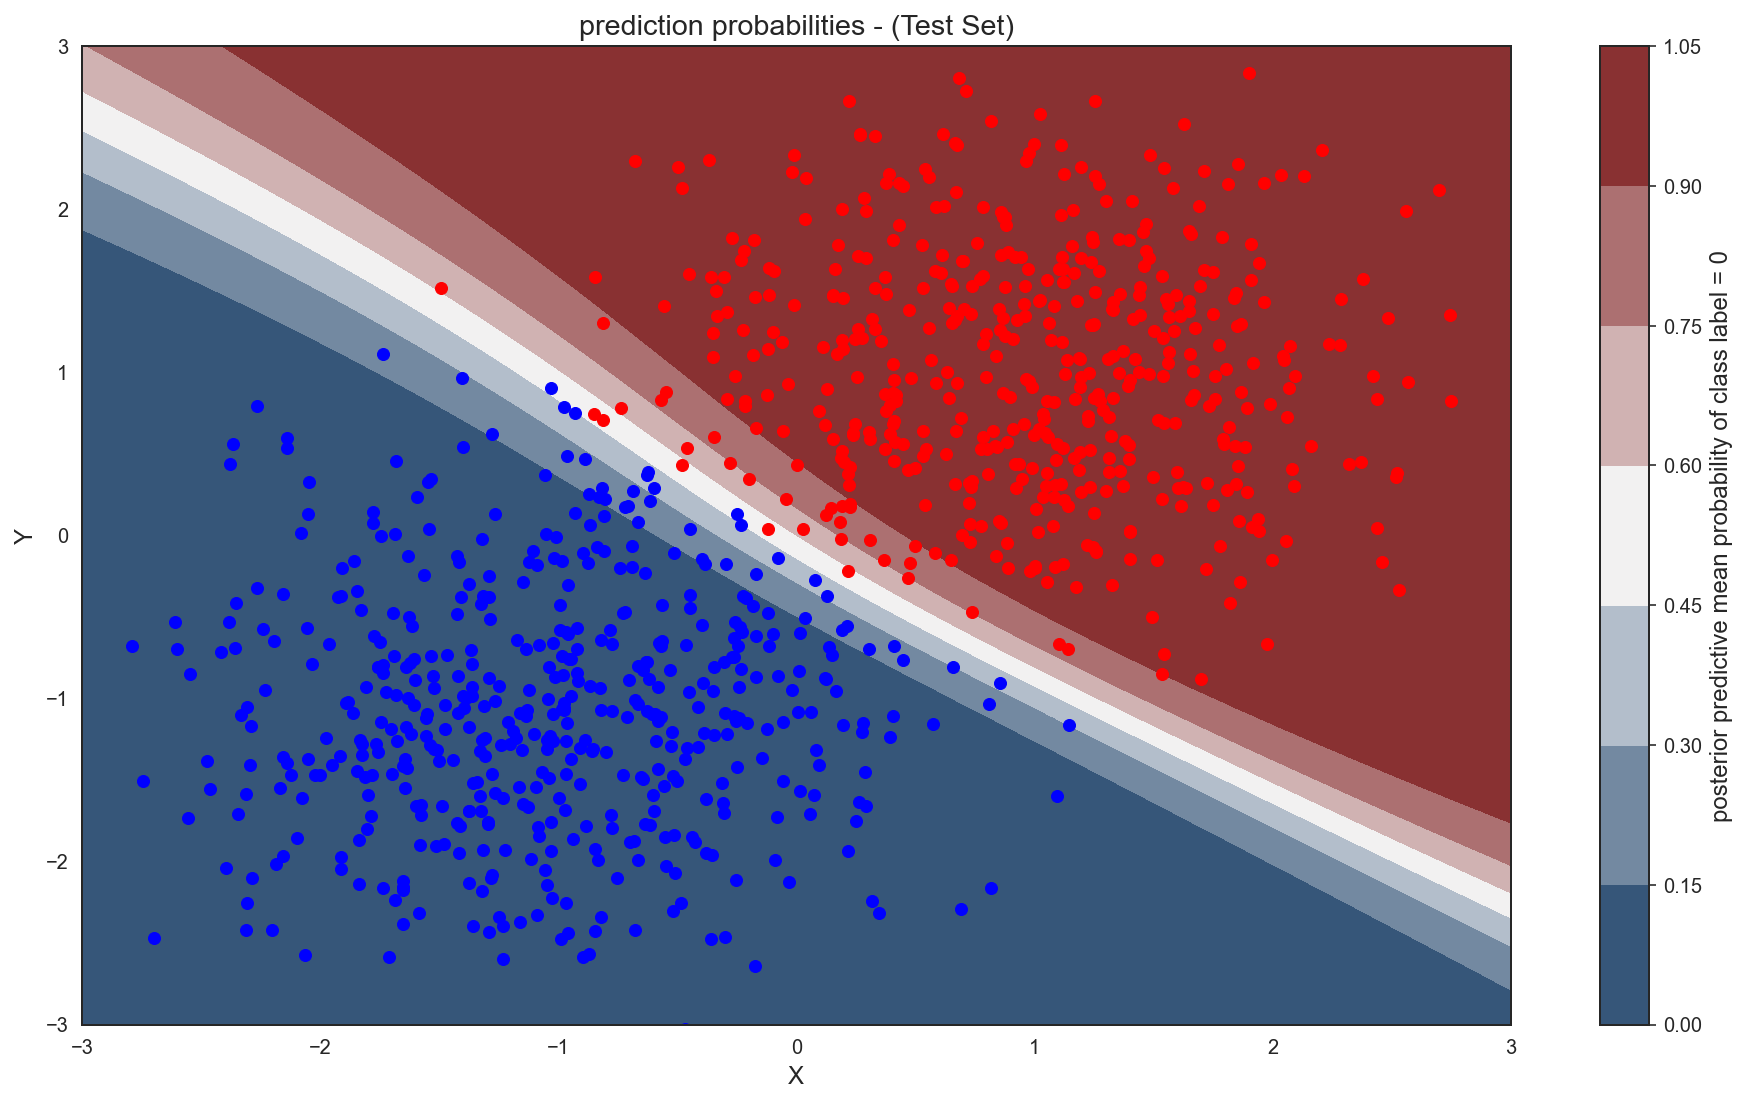

In [37]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], pred2.reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1], color='b')
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
plt.title("prediction probabilities - (Test Set)")
cbar.ax.set_ylabel('posterior predictive mean probability of class label = 0')

## Deep Ensemble with Random Initialization

In [38]:
ensembles = 30
ens_test_probs = []
ens_ood_probs = []
ens_weights = []
grid_preds = []

for i in range(ensembles):
    
    # Fit neural network model
    model = get_model(mc=False)
    nn = model.fit(X_train, Y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        callbacks=[es],
                    validation_data=(X_test, Y_test))
    
    #Get Dense model weights
    weights = model.get_weights()
    flat_weight_array = np.array([])
    for weight in weights:
        flat_weight_array = np.concatenate((flat_weight_array, weight.flatten()))
    ens_weights.append(flat_weight_array)
    
    # Accuracy of model
    score = model.evaluate(X_test, Y_test, verbose=0)
    #print('Test loss:', np.round(score[0],2))
    test_prob = model.predict(X_test)
    
    ens_test_probs.append(test_prob)
    print("Iteration: " + str(i+1) +' Test accuracy:'+ str(np.round(score[1],4)))
        
    #Predictions & uncertainty for test points
    ood_prob = model.predict(np.array(test_points))
    ens_ood_probs.append(ood_prob)

    pred2 = model.predict(grid_2d)[:,0].flatten()
    grid_preds.append(pred2)

Iteration: 1 Test accuracy:0.973
Iteration: 2 Test accuracy:0.972
Iteration: 3 Test accuracy:0.972
Iteration: 4 Test accuracy:0.972
Iteration: 5 Test accuracy:0.972
Iteration: 6 Test accuracy:0.973
Iteration: 7 Test accuracy:0.973
Iteration: 8 Test accuracy:0.972
Iteration: 9 Test accuracy:0.972
Iteration: 10 Test accuracy:0.972
Iteration: 11 Test accuracy:0.973
Iteration: 12 Test accuracy:0.972
Iteration: 13 Test accuracy:0.973
Iteration: 14 Test accuracy:0.972
Iteration: 15 Test accuracy:0.972
Iteration: 16 Test accuracy:0.972
Iteration: 17 Test accuracy:0.973
Iteration: 18 Test accuracy:0.972
Iteration: 19 Test accuracy:0.972
Iteration: 20 Test accuracy:0.973
Iteration: 21 Test accuracy:0.973
Iteration: 22 Test accuracy:0.972
Iteration: 23 Test accuracy:0.973
Iteration: 24 Test accuracy:0.973
Iteration: 25 Test accuracy:0.973
Iteration: 26 Test accuracy:0.974
Iteration: 27 Test accuracy:0.973
Iteration: 28 Test accuracy:0.972
Iteration: 29 Test accuracy:0.971
Iteration: 30 Test accu

In [39]:
ens_mean = np.mean(np.array(ens_test_probs),axis=0)
pred_test_labels = (ens_mean > 0.5).astype(np.int) 
score = accuracy_score(Y_test, pred_test_labels)
print("Ensemble prediction accuracy score for test data: ", score)

Ensemble prediction accuracy score for test data:  0.973


In [40]:
ens_variance = np.std(np.array(ens_ood_probs),axis=0)**2

for i in range(len(test_points)):
    print("uncertainty for test point: {} : {}".format(test_points[i], ens_variance[i][0]))

uncertainty for test point: (-5, -5) : 2.498767059933016e-07
uncertainty for test point: (-5, 3.5) : 0.008461144752800465
uncertainty for test point: (5, 5) : 1.897921606541786e-07
uncertainty for test point: (5, -3.5) : 0.02037452720105648
uncertainty for test point: (-1, 1) : 0.0017002299427986145
uncertainty for test point: (-1, -1.5) : 2.1586001253126597e-07
uncertainty for test point: (1, 1.5) : 1.7318986067493825e-07


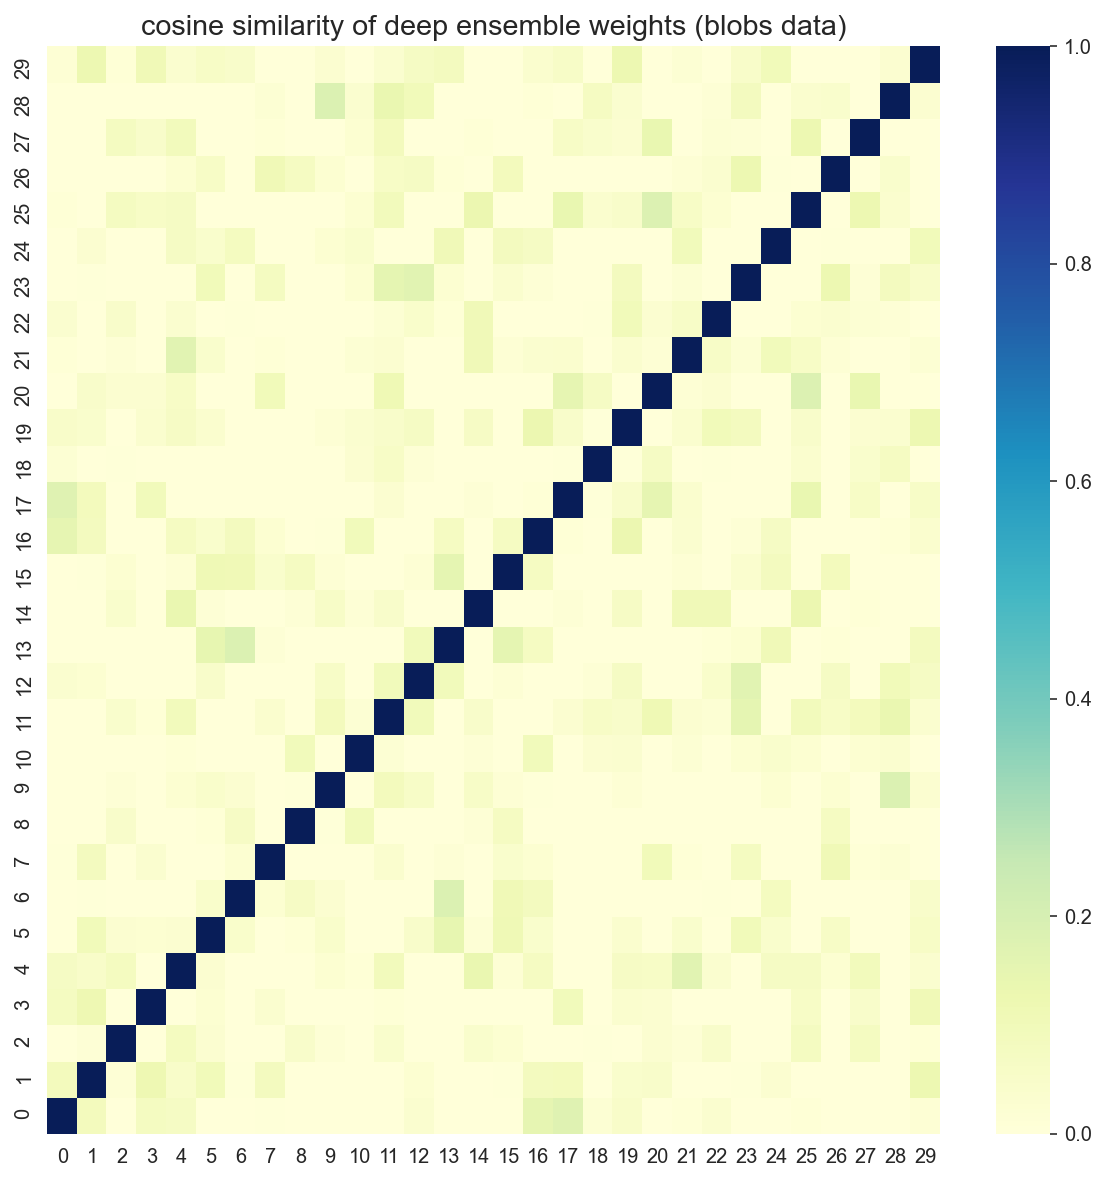

In [41]:
df = pd.DataFrame(np.array(ens_weights))

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(cosine_similarity(df),vmin=0, vmax=1, cmap="YlGnBu") # vmin=0.9, vmax=1
plt.title("cosine similarity of deep ensemble weights ({} data)".format(TOY_DATA_TYPE))
ax.invert_yaxis()
plt.savefig("{}_cos_similarity_plot_ensemble.png".format(TOY_DATA_TYPE))

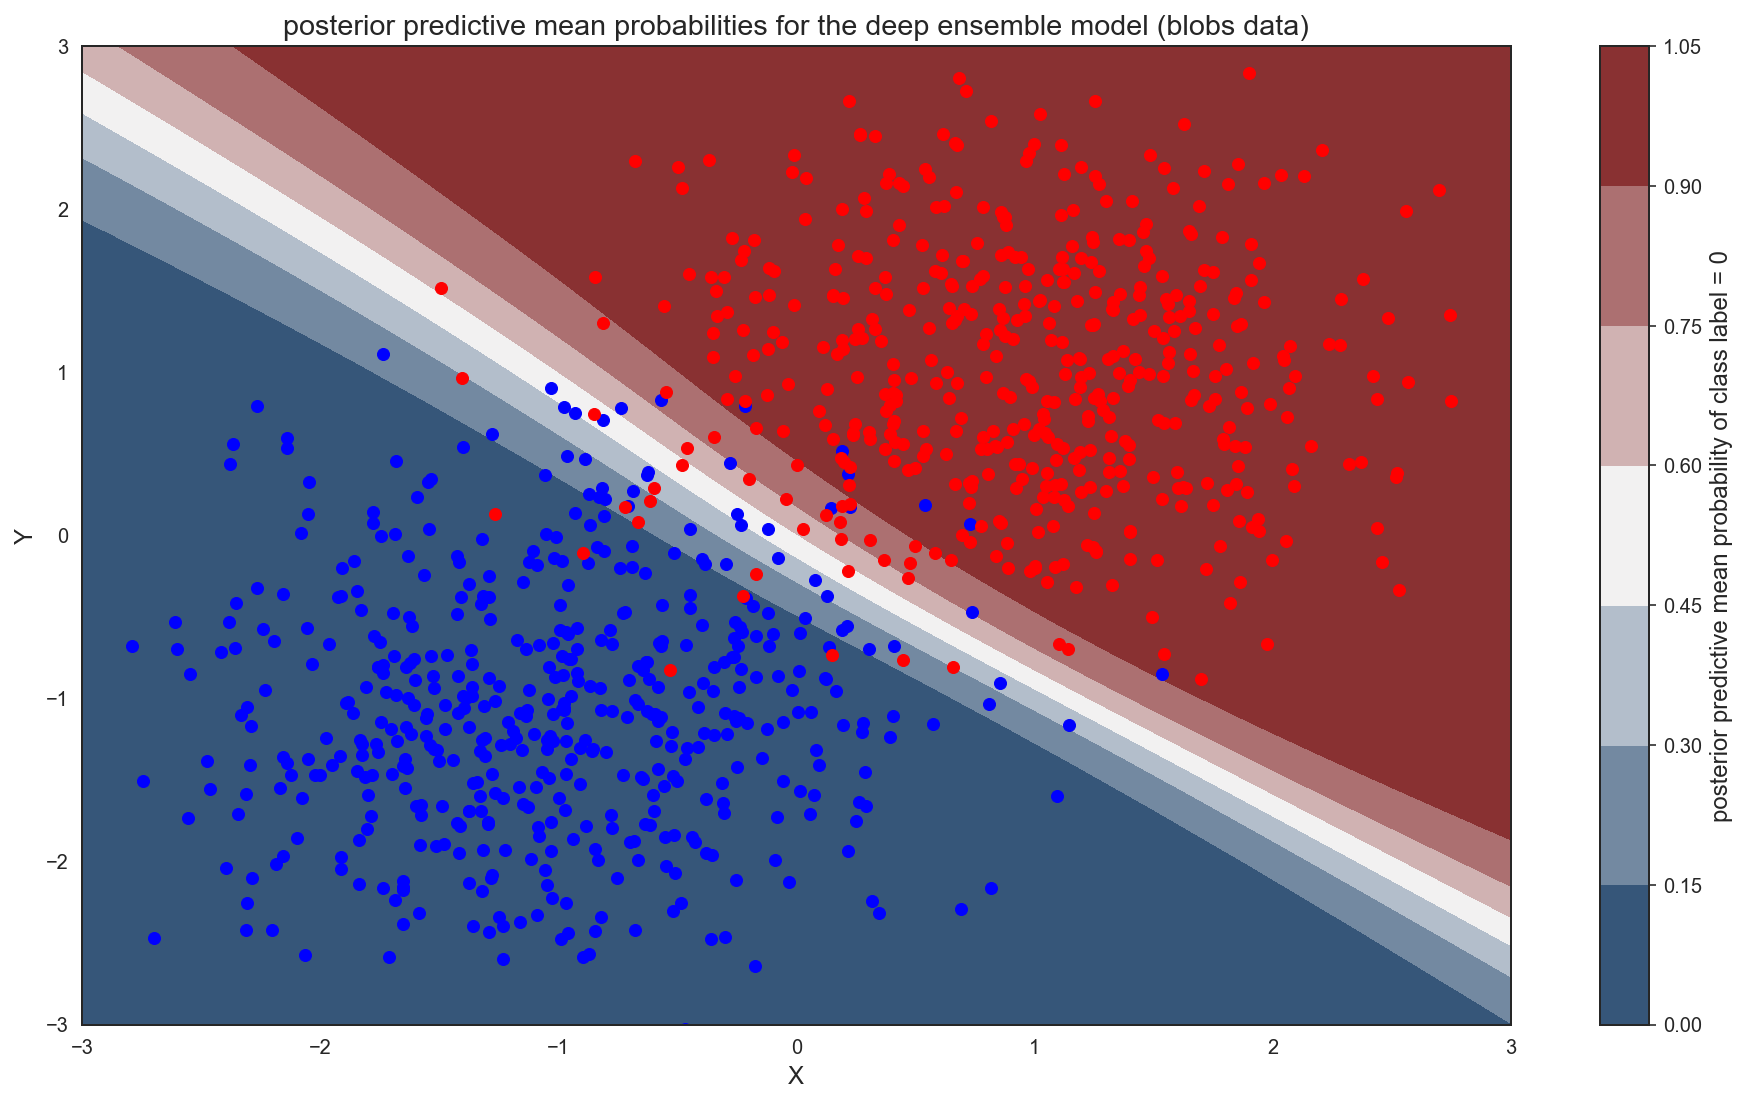

In [42]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.mean(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive mean probabilities for the deep ensemble model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('posterior predictive mean probability of class label = 0')
plt.savefig("{}_posterior_predictive_plot_ensemble.png".format(TOY_DATA_TYPE))

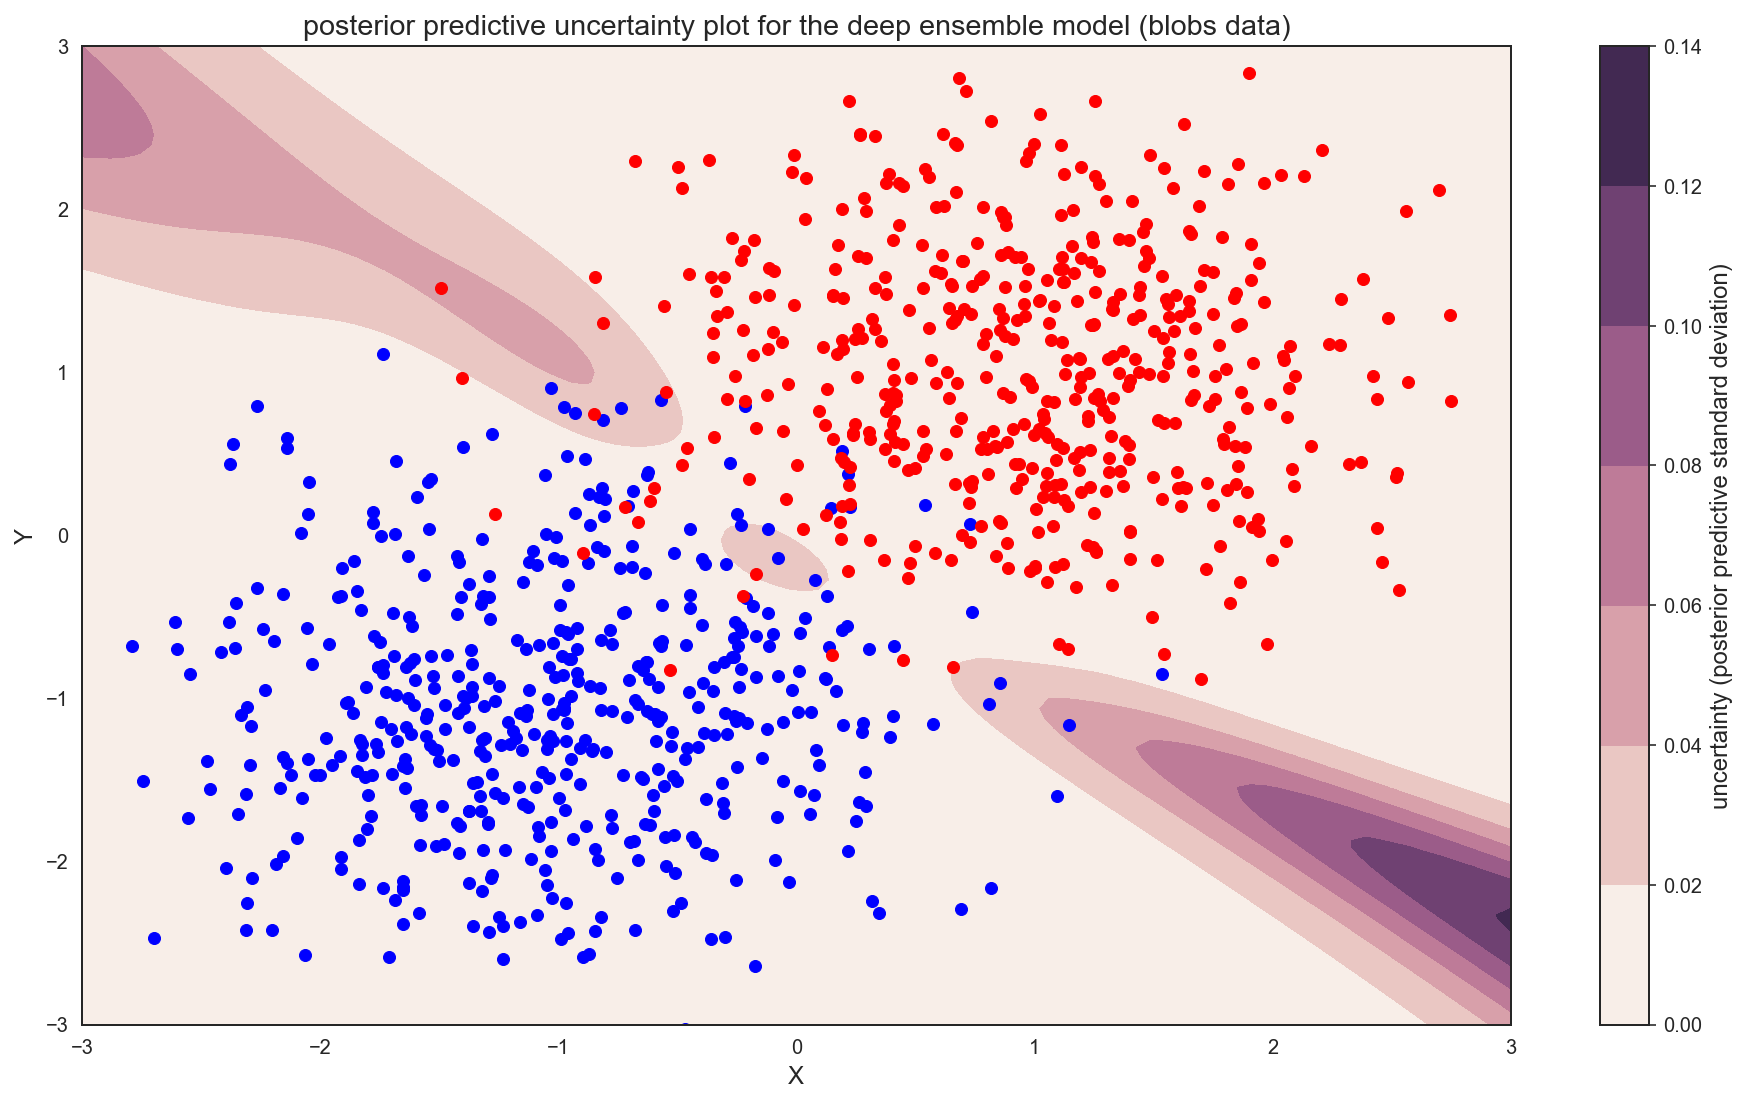

In [43]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.std(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive uncertainty plot for the deep ensemble model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('uncertainty (posterior predictive standard deviation)')
plt.savefig("{}_uncertainty_plot_ensemble.png".format(TOY_DATA_TYPE))

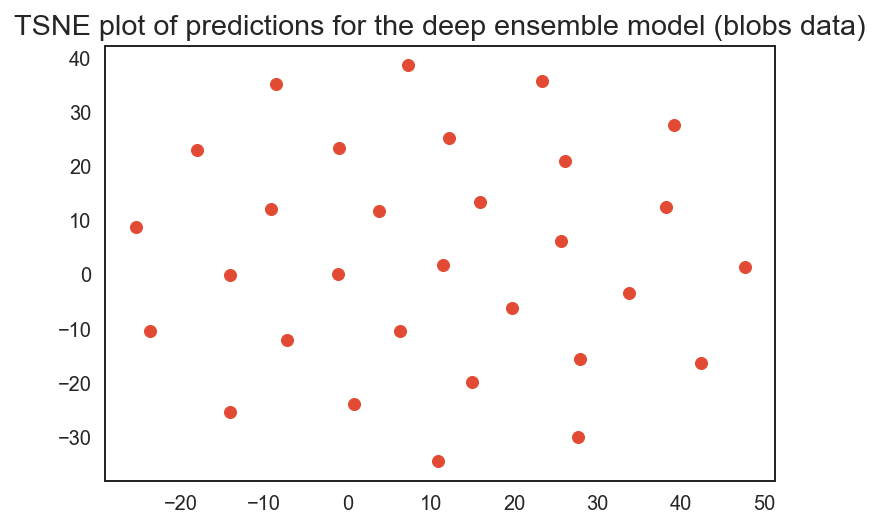

In [44]:
tsne = TSNE(n_components=2)
ens_test_probs_pca = tsne.fit_transform(np.array(ens_test_probs).reshape(30, 1000))


plt.scatter(ens_test_probs_pca[:,0], ens_test_probs_pca[:,1])
plt.title("TSNE plot of predictions for the deep ensemble model ({} data)".format(TOY_DATA_TYPE))
plt.savefig("{}_tsne_plot_ensemble.png".format(TOY_DATA_TYPE))

## Bayesian Dropout Subsampling

In [45]:
bayes_iters = 30
dropout_post_predictions = []
dropout_ood_probs = []
drop_weights = []
grid_preds = []

for i in range(bayes_iters):
    #Generate random p value for Dropout ratio
    p_rand = np.random.random()
    
    drop_model = get_model(mc=True, p=p_rand)
    
    #Initialize model with pre-trained weights
    drop_model.load_weights('initial_model_weights.h5')
    h_mc = drop_model.fit(X_train, Y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        callbacks=[es],
                        validation_data=(X_test, Y_test))
    
    #Get Dense model weights
    weights = drop_model.get_weights()
    flat_weight_array = np.array([])
    for weight in weights:
        flat_weight_array = np.concatenate((flat_weight_array, weight.flatten()))
    drop_weights.append(flat_weight_array)
    
    # Accuracy of model
    score = drop_model.evaluate(X_test, Y_test, verbose=0)
    #print('Test loss:', np.round(score[0],2))
    print("Iteration: " + str(i+1) + " Random p: " + str(np.round(p_rand,2)) + ' Test accuracy: ', str(np.round(score[1],4)))
    
    #Posterior predictions
    y_pred = drop_model.predict(X_test)
    dropout_post_predictions.append(y_pred)
    
    #Predictions & uncertainty for test points
    ood_prob = drop_model.predict(np.array(test_points))
    dropout_ood_probs.append(ood_prob)
    
    pred2 = drop_model.predict(grid_2d)[:,0].flatten()
    grid_preds.append(pred2)

Iteration: 1 Random p: 0.73 Test accuracy:  0.973
Iteration: 2 Random p: 0.03 Test accuracy:  0.973
Iteration: 3 Random p: 0.55 Test accuracy:  0.972
Iteration: 4 Random p: 0.06 Test accuracy:  0.973
Iteration: 5 Random p: 0.16 Test accuracy:  0.973
Iteration: 6 Random p: 0.94 Test accuracy:  0.974
Iteration: 7 Random p: 0.11 Test accuracy:  0.973
Iteration: 8 Random p: 0.6 Test accuracy:  0.973
Iteration: 9 Random p: 0.46 Test accuracy:  0.973
Iteration: 10 Random p: 0.18 Test accuracy:  0.973
Iteration: 11 Random p: 0.72 Test accuracy:  0.973
Iteration: 12 Random p: 0.99 Test accuracy:  0.973
Iteration: 13 Random p: 0.74 Test accuracy:  0.973
Iteration: 14 Random p: 0.81 Test accuracy:  0.973
Iteration: 15 Random p: 0.54 Test accuracy:  0.971
Iteration: 16 Random p: 0.52 Test accuracy:  0.973
Iteration: 17 Random p: 0.73 Test accuracy:  0.975
Iteration: 18 Random p: 0.09 Test accuracy:  0.973
Iteration: 19 Random p: 0.49 Test accuracy:  0.973
Iteration: 20 Random p: 0.57 Test accurac

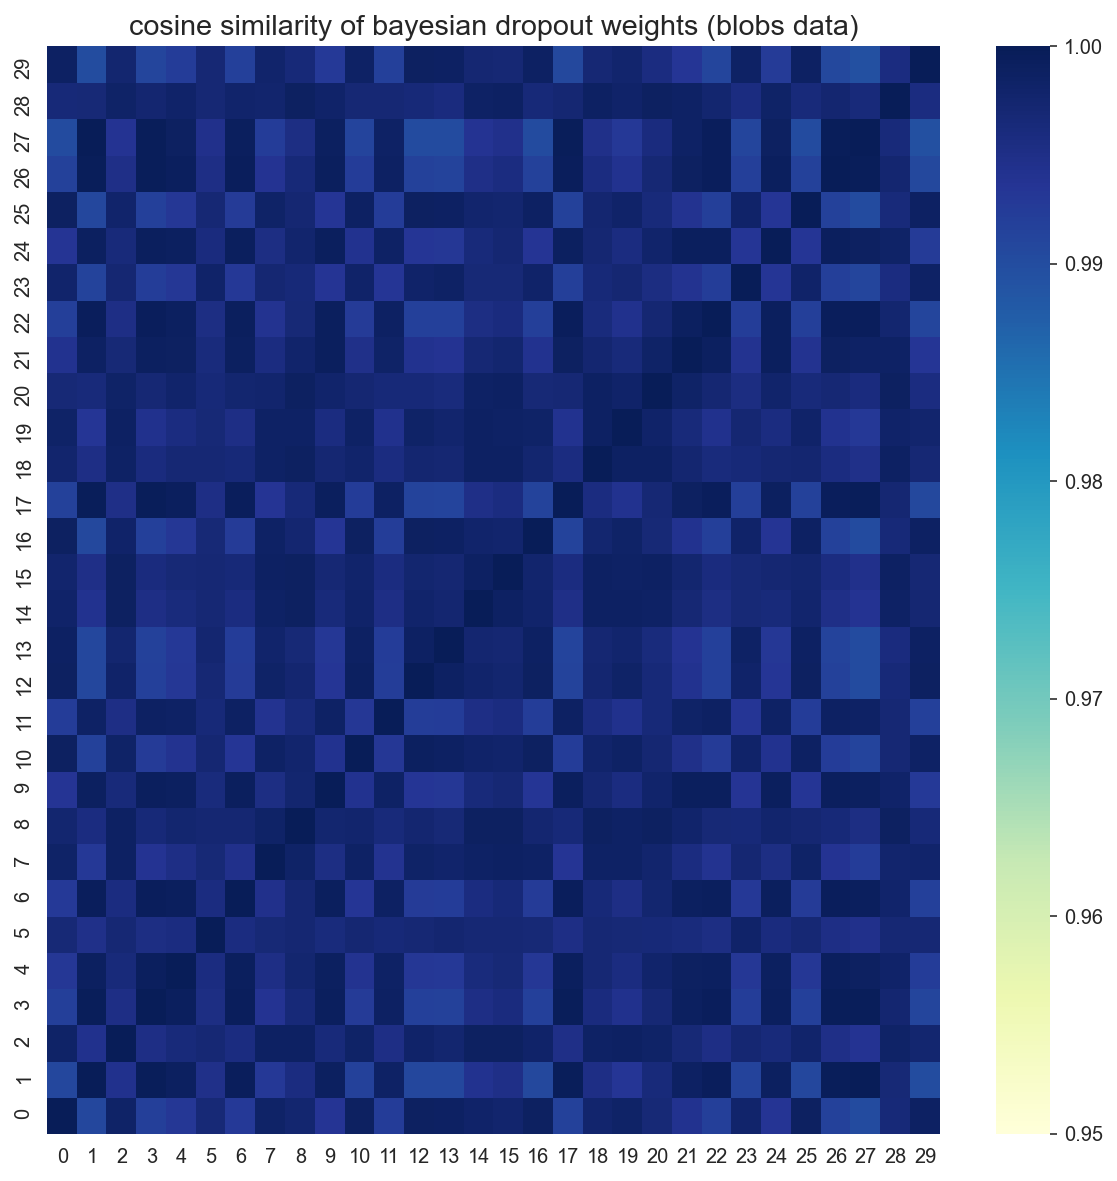

In [46]:
df = pd.DataFrame(np.array(drop_weights))

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(cosine_similarity(df),vmin=0.95, vmax=1, cmap="YlGnBu") # vmin=0.9, vmax=1
plt.title("cosine similarity of bayesian dropout weights ({} data)".format(TOY_DATA_TYPE))
ax.invert_yaxis()
plt.savefig("{}_cos_similarity_plot_dropout.png".format(TOY_DATA_TYPE))

In [47]:
dropout_posterior_mean_preds = np.mean(np.array(dropout_post_predictions),axis=0)
dropout_posterior_mean_preds.shape

(1000, 1)

In [48]:
dropout_pred_test_labels = (dropout_posterior_mean_preds > 0.5).astype(np.int) 
dropout_acc_score = accuracy_score(Y_test, dropout_pred_test_labels)
print("Bayesian Dropout posterior predictive mean accuracy score for test data: ", dropout_acc_score)

Bayesian Dropout posterior predictive mean accuracy score for test data:  0.973


In [49]:
drop_ood_variance = np.std(np.array(dropout_ood_probs),axis=0)**2

for i in range(len(test_points)):
    print("uncertainty for test point: {} : {}".format(test_points[i], drop_ood_variance[i][0]))

uncertainty for test point: (-5, -5) : 9.920687205067225e-08
uncertainty for test point: (-5, 3.5) : 0.00776449590921402
uncertainty for test point: (5, 5) : 9.646914378436122e-08
uncertainty for test point: (5, -3.5) : 0.017118485644459724
uncertainty for test point: (-1, 1) : 0.0025293512735515833
uncertainty for test point: (-1, -1.5) : 4.51488318731208e-07
uncertainty for test point: (1, 1.5) : 1.1996770865607687e-07


In [50]:
dropout_pred_test_labels.shape

(1000, 1)

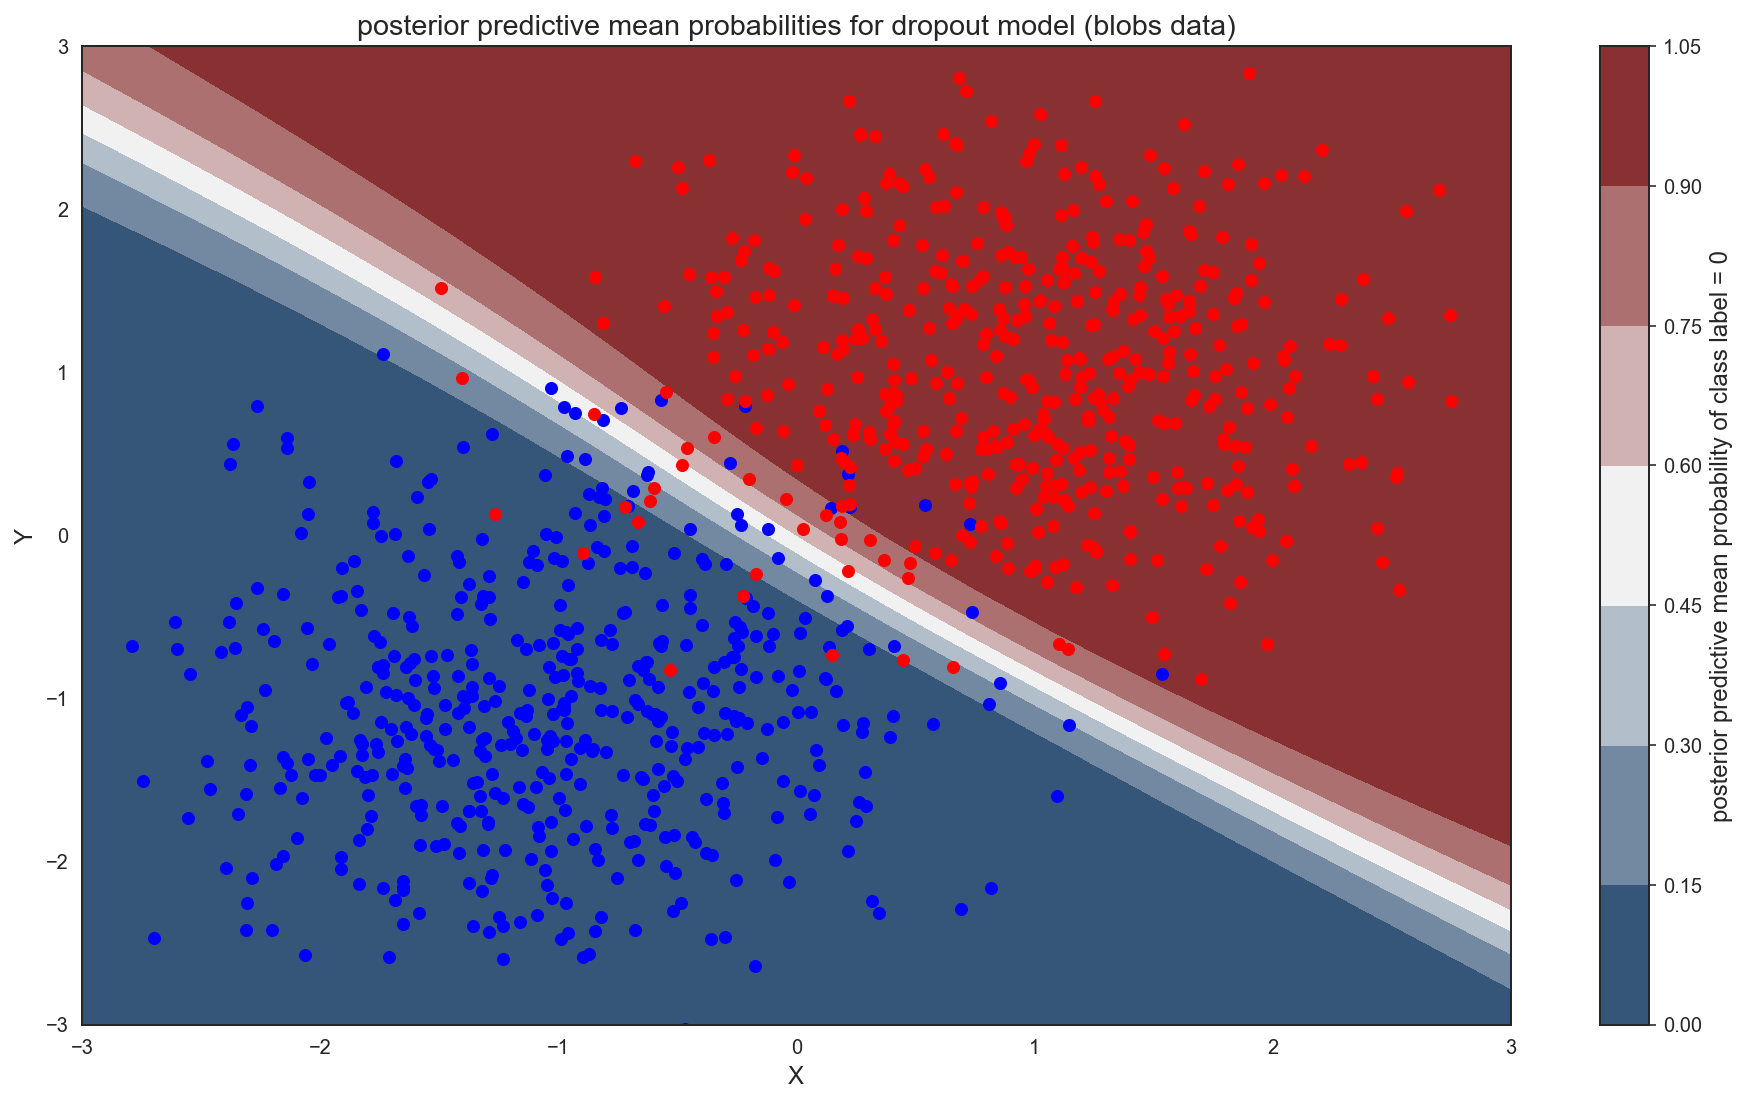

In [51]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.mean(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive mean probabilities for dropout model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('posterior predictive mean probability of class label = 0')
plt.savefig("{}_posterior_predictive_plot_dropout.png".format(TOY_DATA_TYPE))

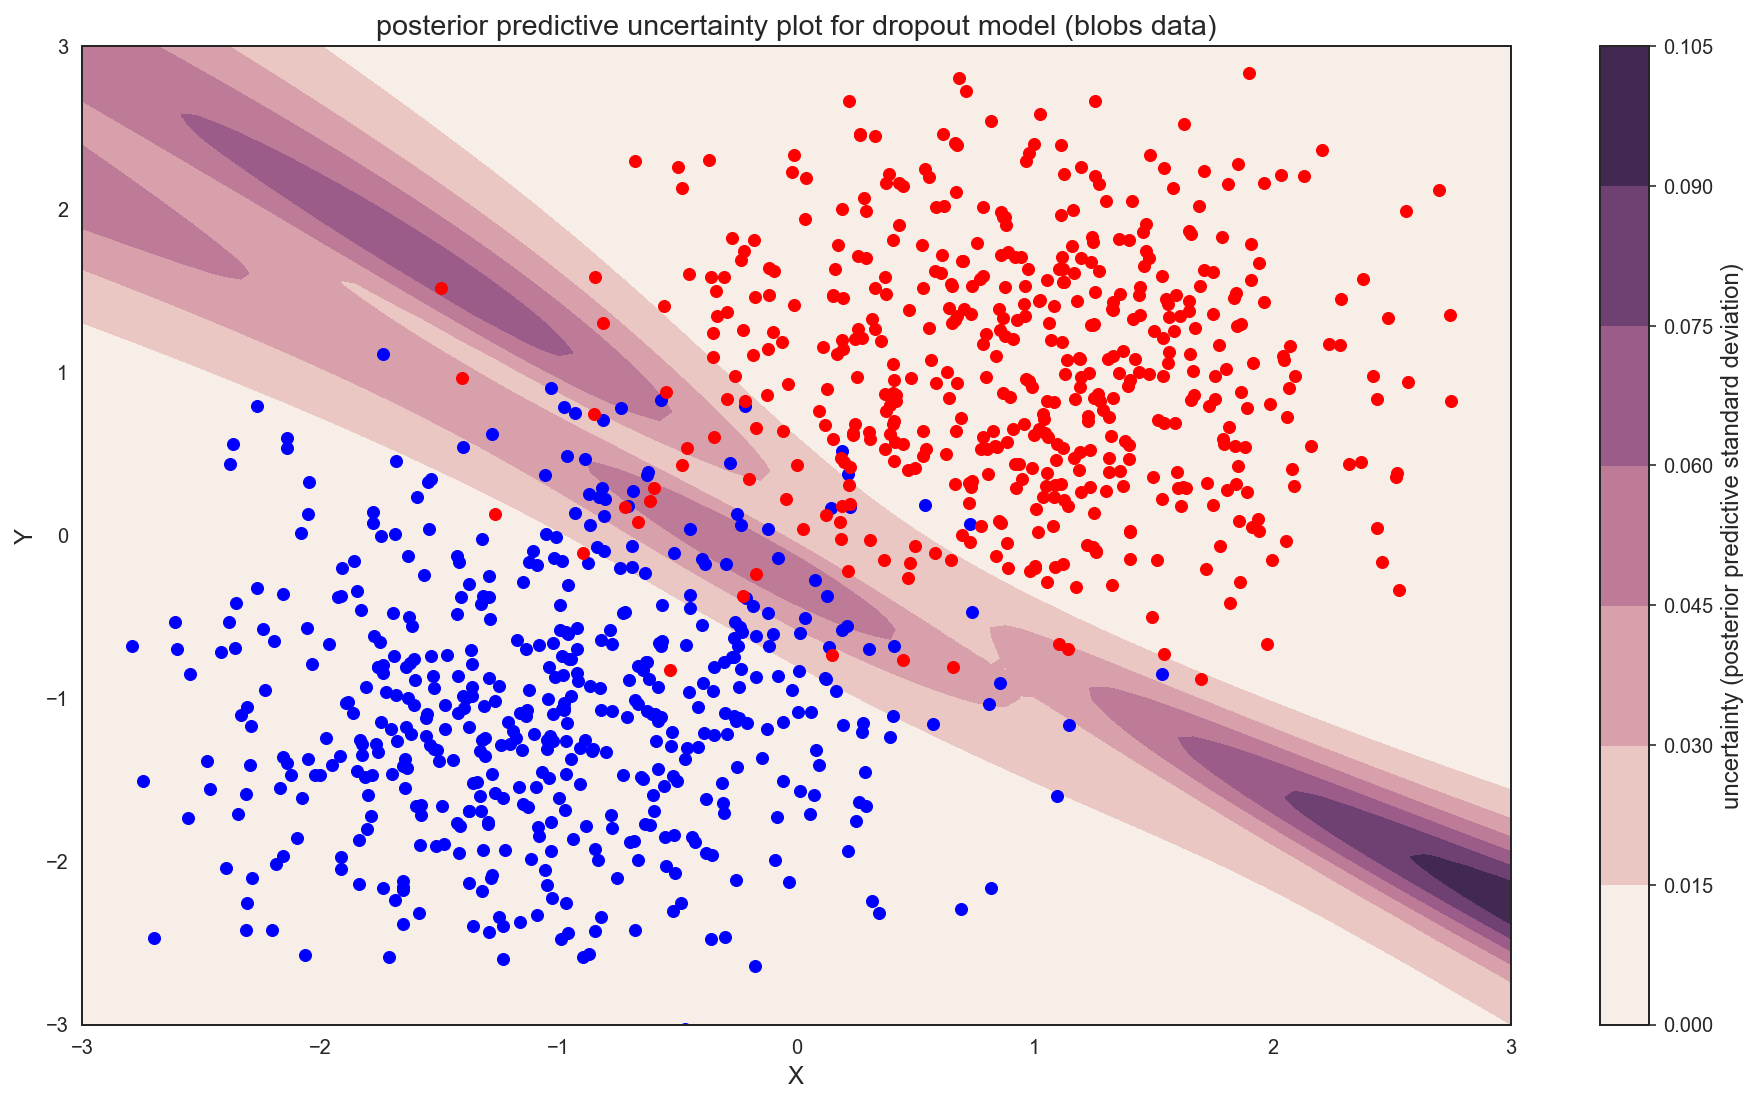

In [52]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.std(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive uncertainty plot for dropout model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('uncertainty (posterior predictive standard deviation)')
plt.savefig("{}_uncertainty_plot_dropout.png".format(TOY_DATA_TYPE))

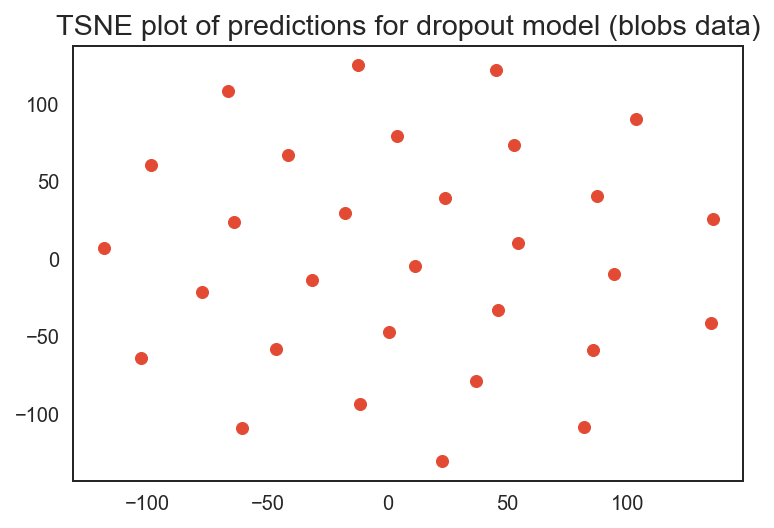

In [53]:
tsne = TSNE(n_components=2)
drop_test_probs_pca = tsne.fit_transform(np.array(dropout_post_predictions).reshape(30, 1000))


plt.scatter(drop_test_probs_pca[:,0], drop_test_probs_pca[:,1])
plt.title("TSNE plot of predictions for dropout model ({} data)".format(TOY_DATA_TYPE))
plt.savefig("{}_tsne_plot_dropout.png".format(TOY_DATA_TYPE))

## Random Subspace Sampling

In [54]:
models = []
random_weights= []
# iterate over different samples
for i in range(bayes_iters):
    # make a new NN with the same layout
    model2 = get_model(mc=False)
    # add random vector to presaved model weights
    model2.load_weights('initial_model_weights.h5')
    #Added scale to regularize randomness
    weights = [model2.get_weights()[j] + np.random.normal(size = model2.get_weights()[j].shape, scale=0.2) for j in range(len(model.get_weights()))]
    model2.set_weights(weights)
    #Get Dense model weights
    weights = model2.get_weights()
    flat_weight_array = np.array([])
    for weight in weights:
        flat_weight_array = np.concatenate((flat_weight_array, weight.flatten()))
    random_weights.append(flat_weight_array)
    models.append(model2)

In [55]:
random_post_predictions = []
grid_preds = []
random_ood_probs = []

for model in models: 
    y_pred = model.predict(X_test)
    random_post_predictions.append(y_pred)
    pred2 = model.predict(grid_2d)[:,0].flatten()
    grid_preds.append(pred2)
    #Predictions & uncertainty for test points
    ood_prob = model.predict(np.array(test_points))
    random_ood_probs.append(ood_prob)
    
random_posterior_mean_preds = np.mean(np.array(random_post_predictions),axis=0)
random_pred_test_labels = (random_posterior_mean_preds > 0.5).astype(np.int) 
random_acc_score = accuracy_score(Y_test, random_pred_test_labels)
print("Random subspace posterior predictive Test set mean accuracy score for test data: ", random_acc_score)

Random subspace posterior predictive Test set mean accuracy score for test data:  0.969


In [56]:
random_ood_variance = np.std(np.array(random_ood_probs),axis=0)**2

for i in range(len(test_points)):
    print("uncertainty for test point: {} : {}".format(test_points[i], random_ood_variance[i][0]))

uncertainty for test point: (-5, -5) : 1.983430774998851e-05
uncertainty for test point: (-5, 3.5) : 0.10341043025255203
uncertainty for test point: (5, 5) : 3.0830684409011155e-05
uncertainty for test point: (5, -3.5) : 0.09038771688938141
uncertainty for test point: (-1, 1) : 0.06621185690164566
uncertainty for test point: (-1, -1.5) : 0.0005730838747695088
uncertainty for test point: (1, 1.5) : 3.749237657757476e-05


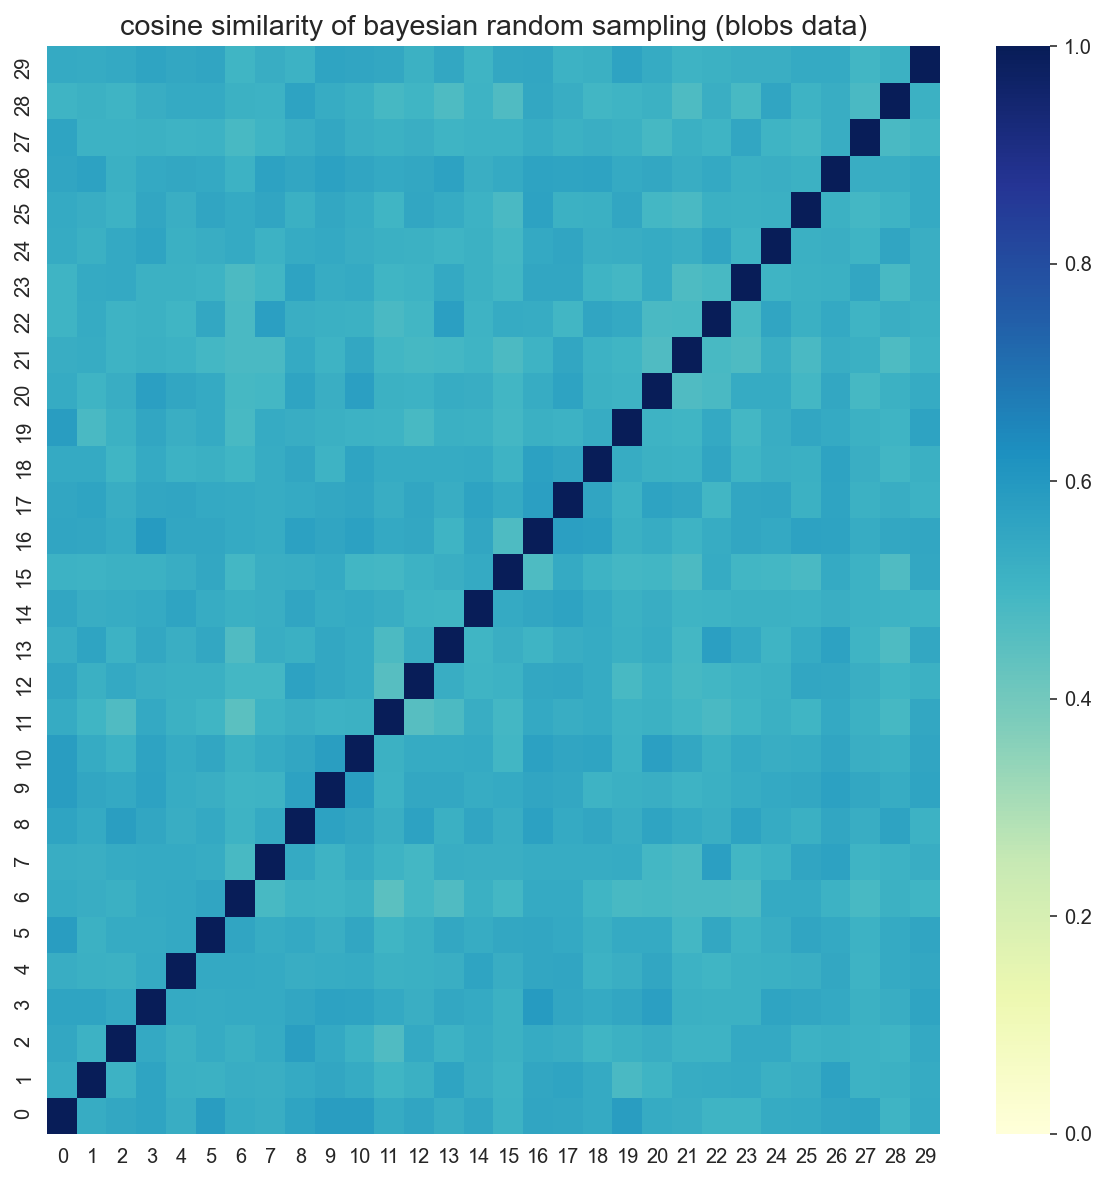

In [57]:
df = pd.DataFrame(np.array(random_weights))

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(cosine_similarity(df),vmin=0, vmax=1, cmap="YlGnBu") # vmin=0.9, vmax=1
plt.title("cosine similarity of bayesian random sampling ({} data)".format(TOY_DATA_TYPE))
ax.invert_yaxis()
plt.savefig("{}_cosine_similarity_plot_random.png".format(TOY_DATA_TYPE))


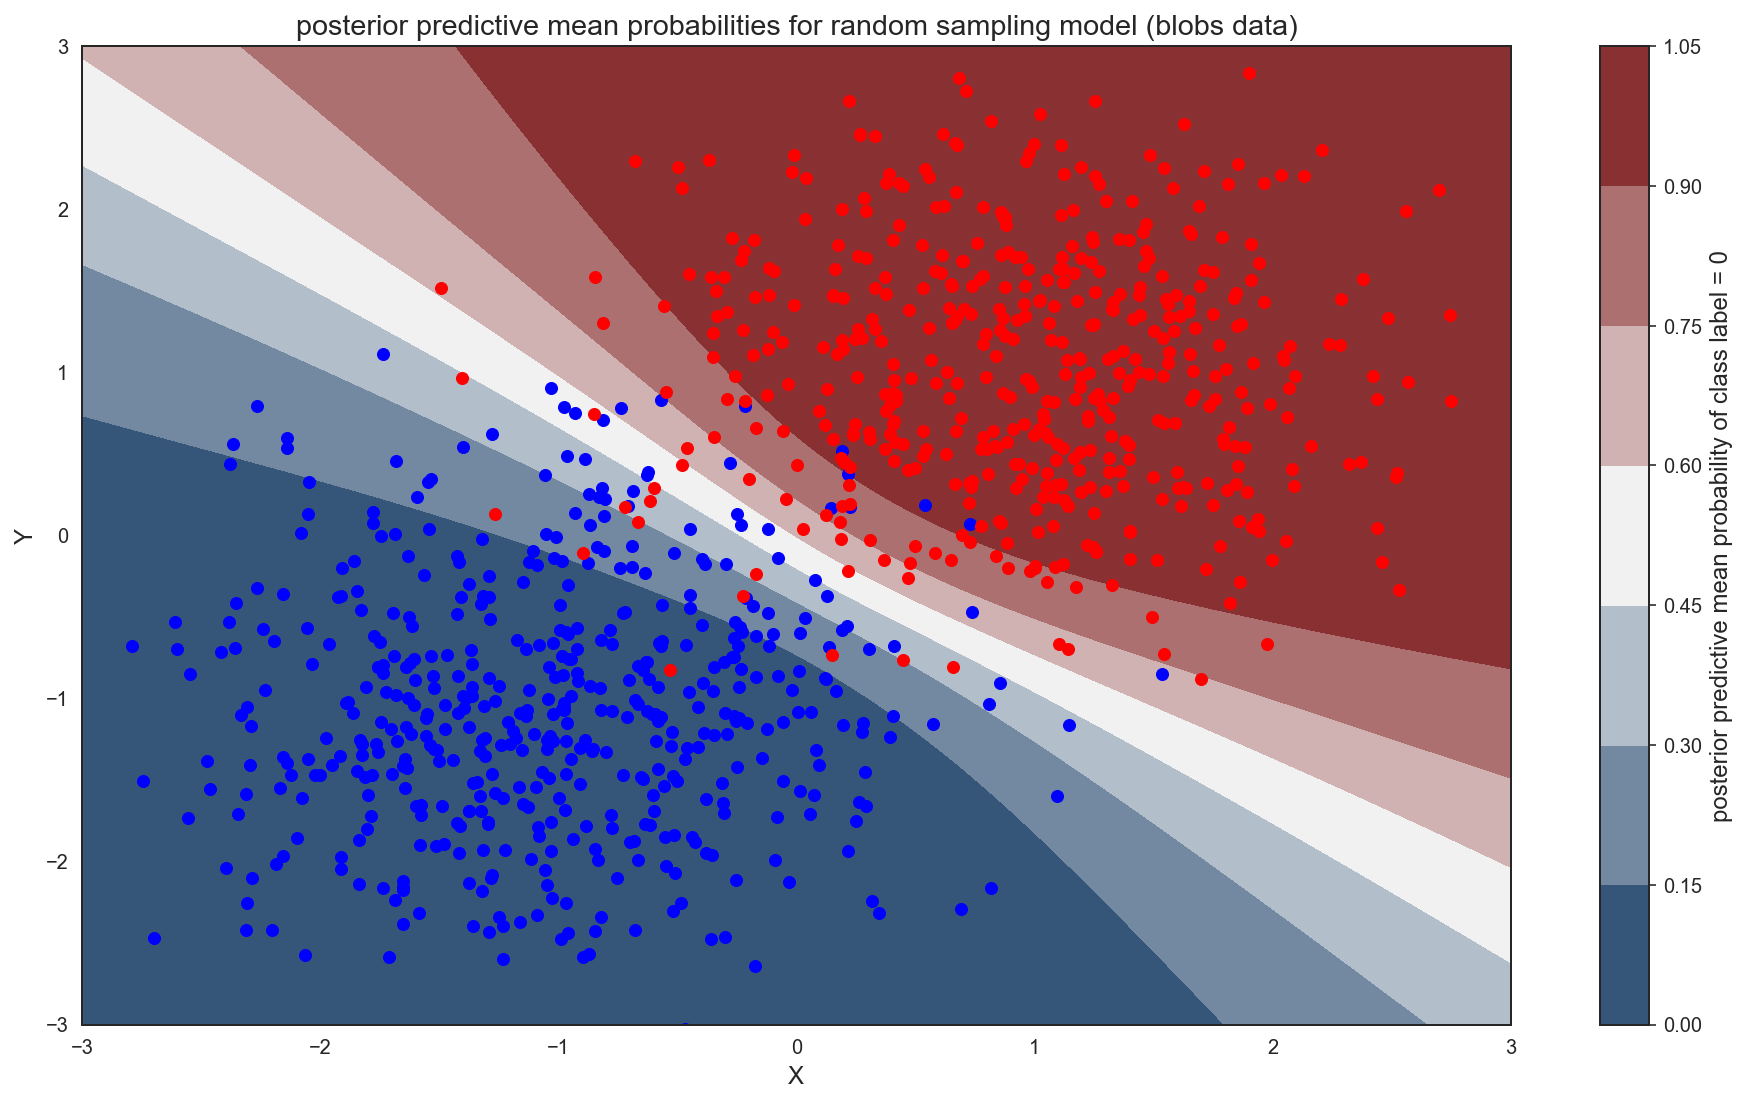

In [58]:
fig, ax = plt.subplots(figsize=(16, 9))
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
contour = ax.contourf(grid[0], grid[1], np.mean(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive mean probabilities for random sampling model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('posterior predictive mean probability of class label = 0')
plt.savefig("{}_posterior_predictive_plot_random.png".format(TOY_DATA_TYPE))

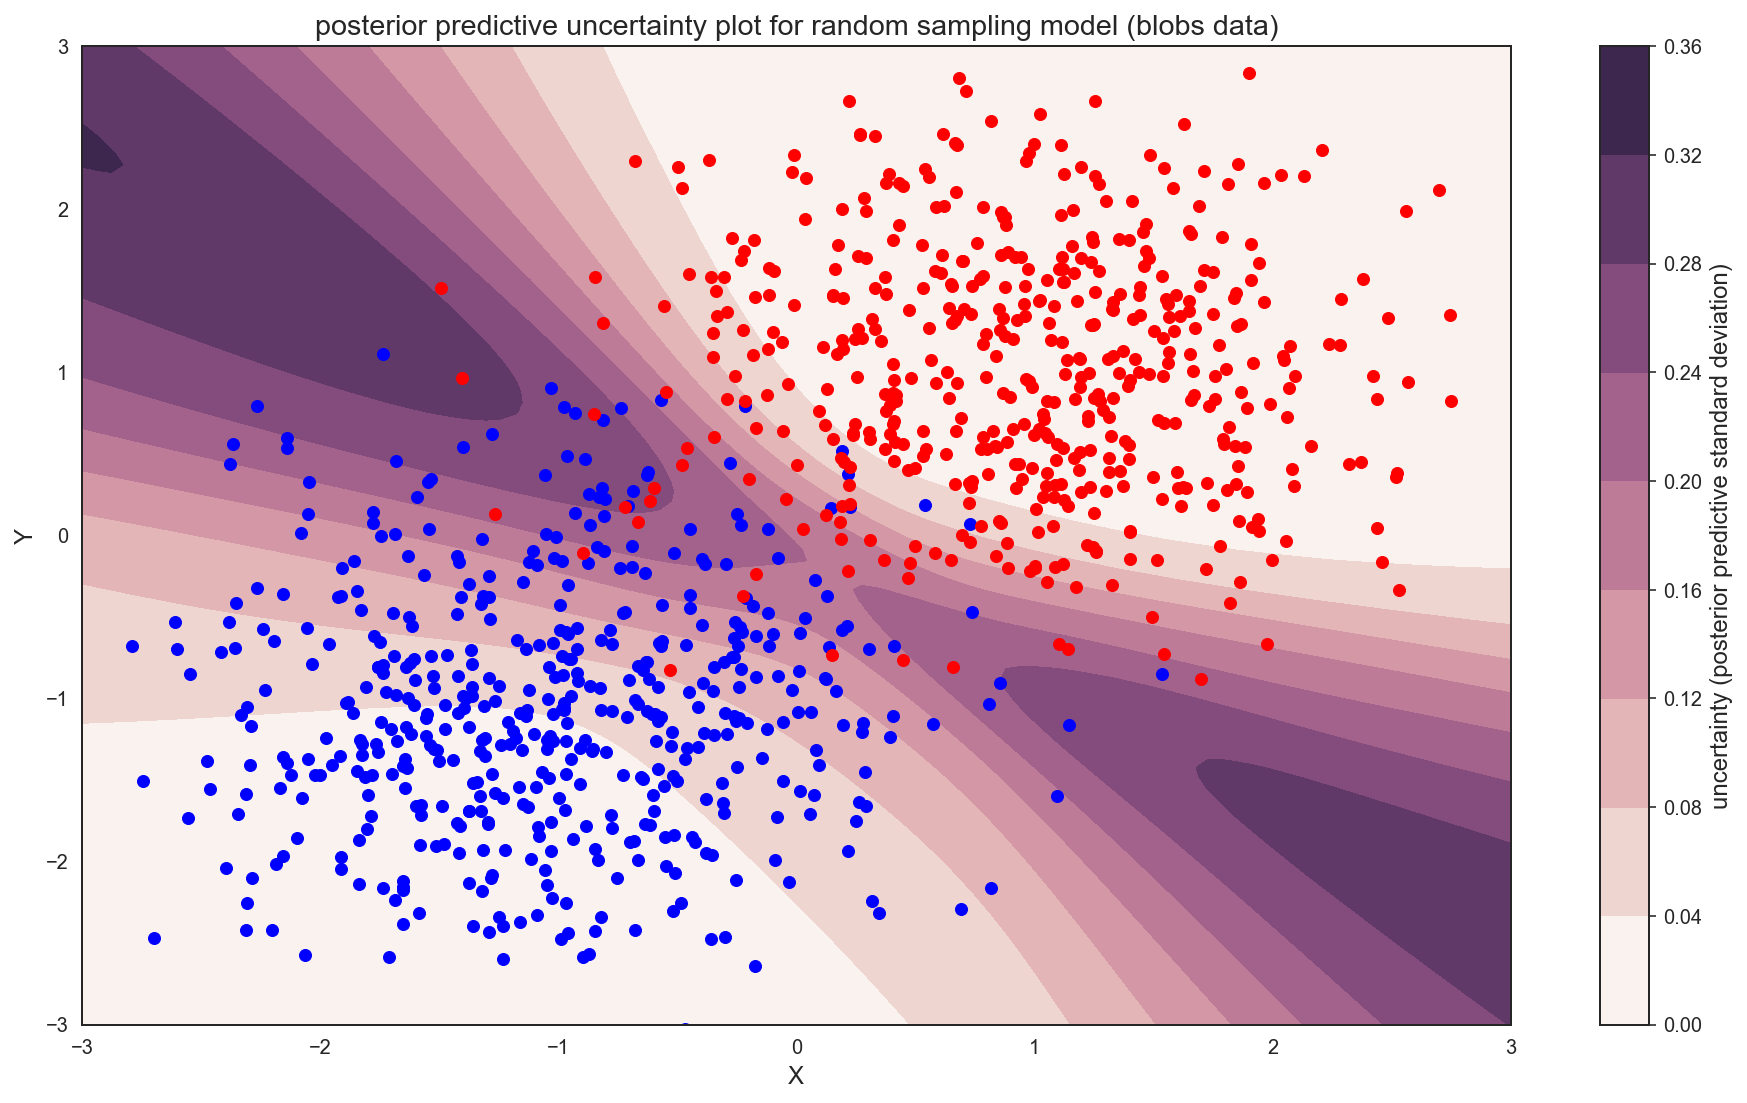

In [59]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.std(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive uncertainty plot for random sampling model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('uncertainty (posterior predictive standard deviation)')
plt.savefig("{}_posterior_uncertainty_plot_random.png".format(TOY_DATA_TYPE))

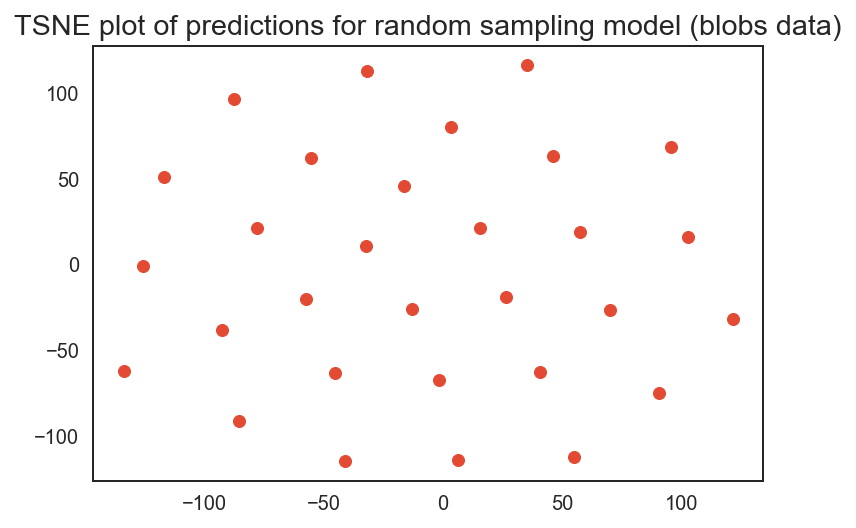

In [60]:
tsne = TSNE(n_components=2)
rand_test_probs_pca = tsne.fit_transform(np.array(random_post_predictions).reshape(30, 1000))


plt.scatter(rand_test_probs_pca[:,0], rand_test_probs_pca[:,1])
plt.title("TSNE plot of predictions for random sampling model ({} data)".format(TOY_DATA_TYPE))
plt.savefig("{}_tsne_plot_random.png".format(TOY_DATA_TYPE))

### HMC

In [61]:
def construct_nn(ann_input, ann_output):
    n_hidden1 = 64
    n_hidden2 = 8

    # Initialize random weights between each layer
    model = get_model(mc=False)
    model.load_weights('initial_model_weights.h5')
    ws = model.get_weights()
    init_1 = ws[0].astype(floatX)
    init_2 = ws[2].astype(floatX)
    init_out = ws[4].flatten().astype(floatX)
    init_b1 = ws[1].astype(floatX)
    init_b2 = ws[3].astype(floatX)
    init_bout = ws[5].astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', ann_input)
        ann_output = pm.Data('ann_output', ann_output)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden1),
                                 testval=init_1)
        biases_in_1 = pm.Normal('b_in_1', 0, sigma=1,
                                 shape=(n_hidden1,),
                                 testval=init_b1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden1, n_hidden2),
                                testval=init_2)
        biases_1_2 = pm.Normal('b_1_2', 0, sigma=1,
                                 shape=(n_hidden2,),
                                 testval=init_b2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden2,),
                                  testval=init_out)
        biases_2_out = pm.Normal('b_3_out', 0, sigma=1,
                                 shape=(1,),
                                 testval=init_bout)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1)+biases_in_1)
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2)+biases_1_2)
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out)+biases_2_out)

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

In [62]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [63]:
with neural_network:
    steps = pm.NUTS()
    #use the specify sampler to sample from the posterior of the model
    trace = pm.sample(5000, step=steps, tune=1000, chains=1)

Sequential sampling (1 chains in 1 job)
NUTS: [b_3_out, w_2_out, b_1_2, w_1_2, b_in_1, w_in_1]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 1858 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [64]:
pm.set_data(new_data={'ann_input': X_test, 'ann_output': Y_test}, model=neural_network)
ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)

In [65]:
pred = ppc["out"].mean(axis=0) > 0.5

In [66]:
print('Test Set Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Test Set Accuracy = 97.1%


In [67]:
pm.set_data(new_data={'ann_input': np.array(test_points), 'ann_output': np.ones(len(test_points), dtype=np.int8)}, model=neural_network)
ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)
ood_variance = np.std(ppc["out"],axis=0)**2

for i in range(len(test_points)):
    print("uncertainty for test point: {} : {}".format(test_points[i], ood_variance[i]))

uncertainty for test point: (-5, -5) : 0.007936000000000023
uncertainty for test point: (-5, 3.5) : 0.23700399999999924
uncertainty for test point: (5, 5) : 0.007936000000000035
uncertainty for test point: (5, -3.5) : 0.21236399999999994
uncertainty for test point: (-1, 1) : 0.24769599999999733
uncertainty for test point: (-1, -1.5) : 0.003984000000000013
uncertainty for test point: (1, 1.5) : 0.007936000000000049


In [68]:
pm.set_data(new_data={'ann_input': grid_2d, 'ann_output': dummy_out}, model=neural_network)
ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)

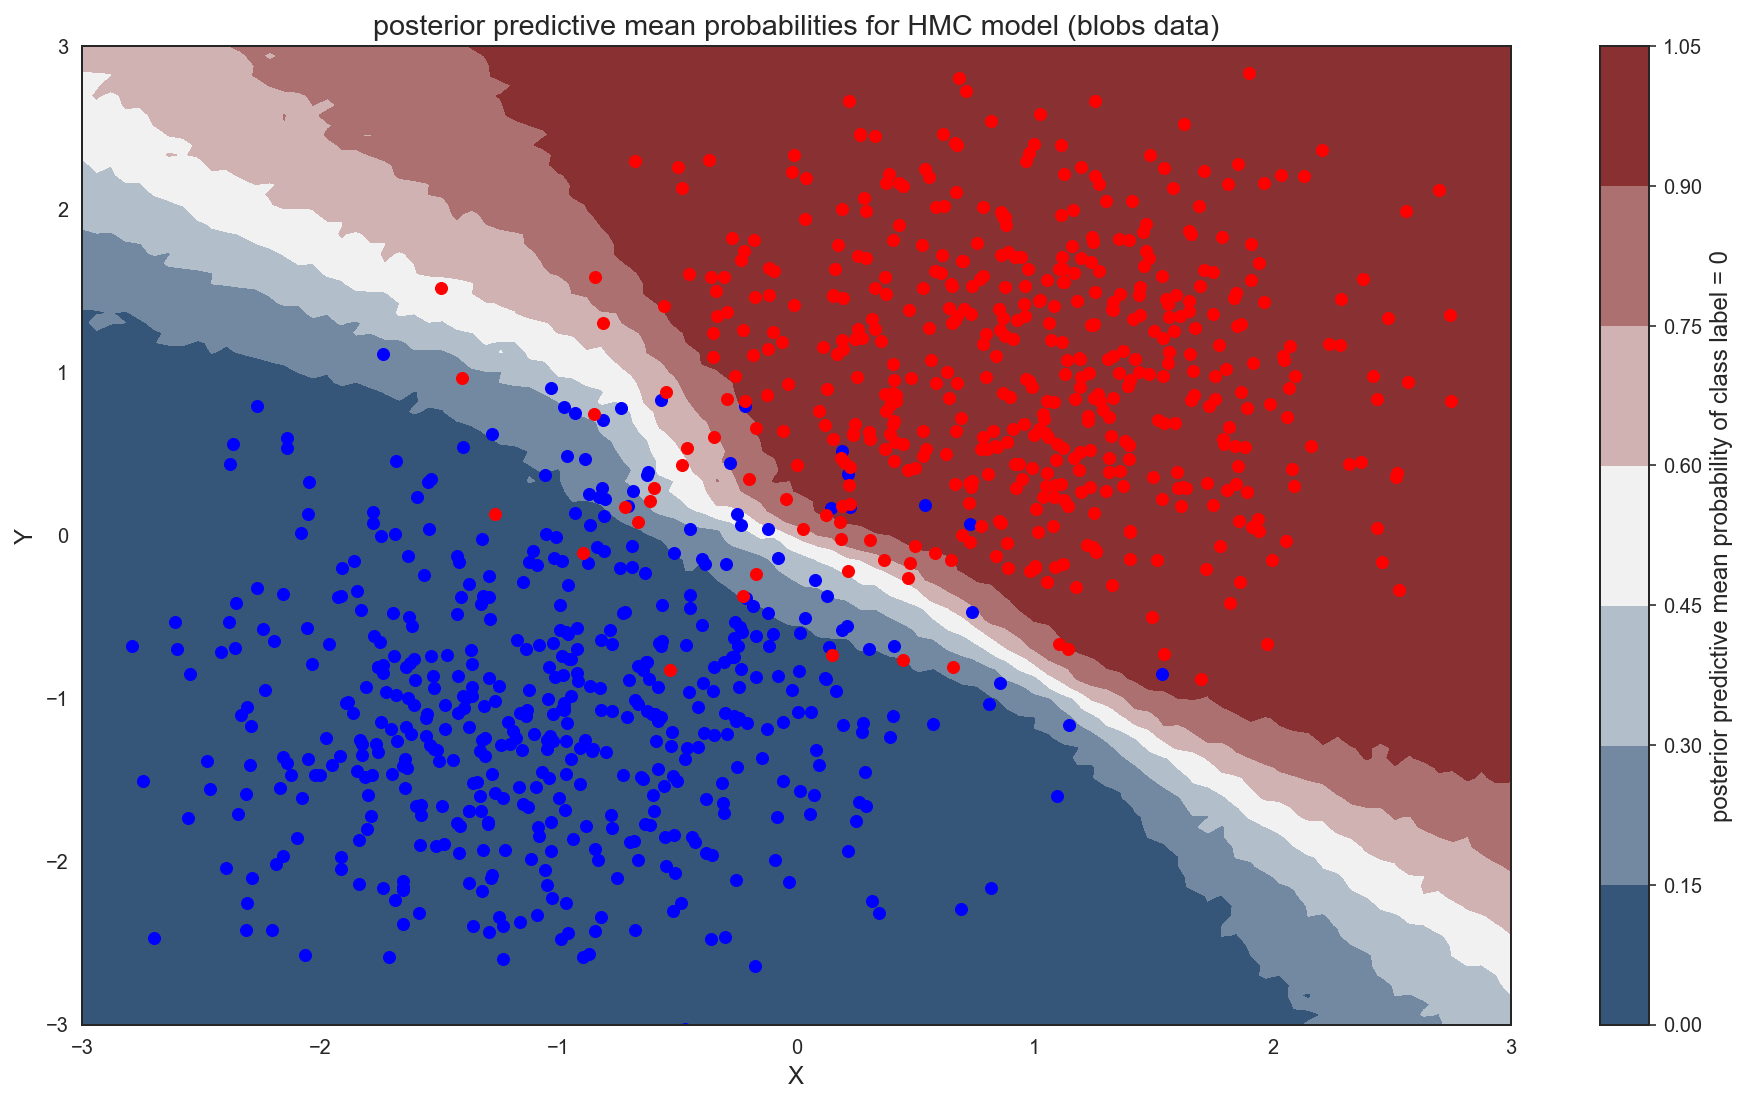

In [69]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc["out"].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive mean probabilities for HMC model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('posterior predictive mean probability of class label = 0')
plt.savefig("{}_posterior_predictive_plot_hmc.png".format(TOY_DATA_TYPE))

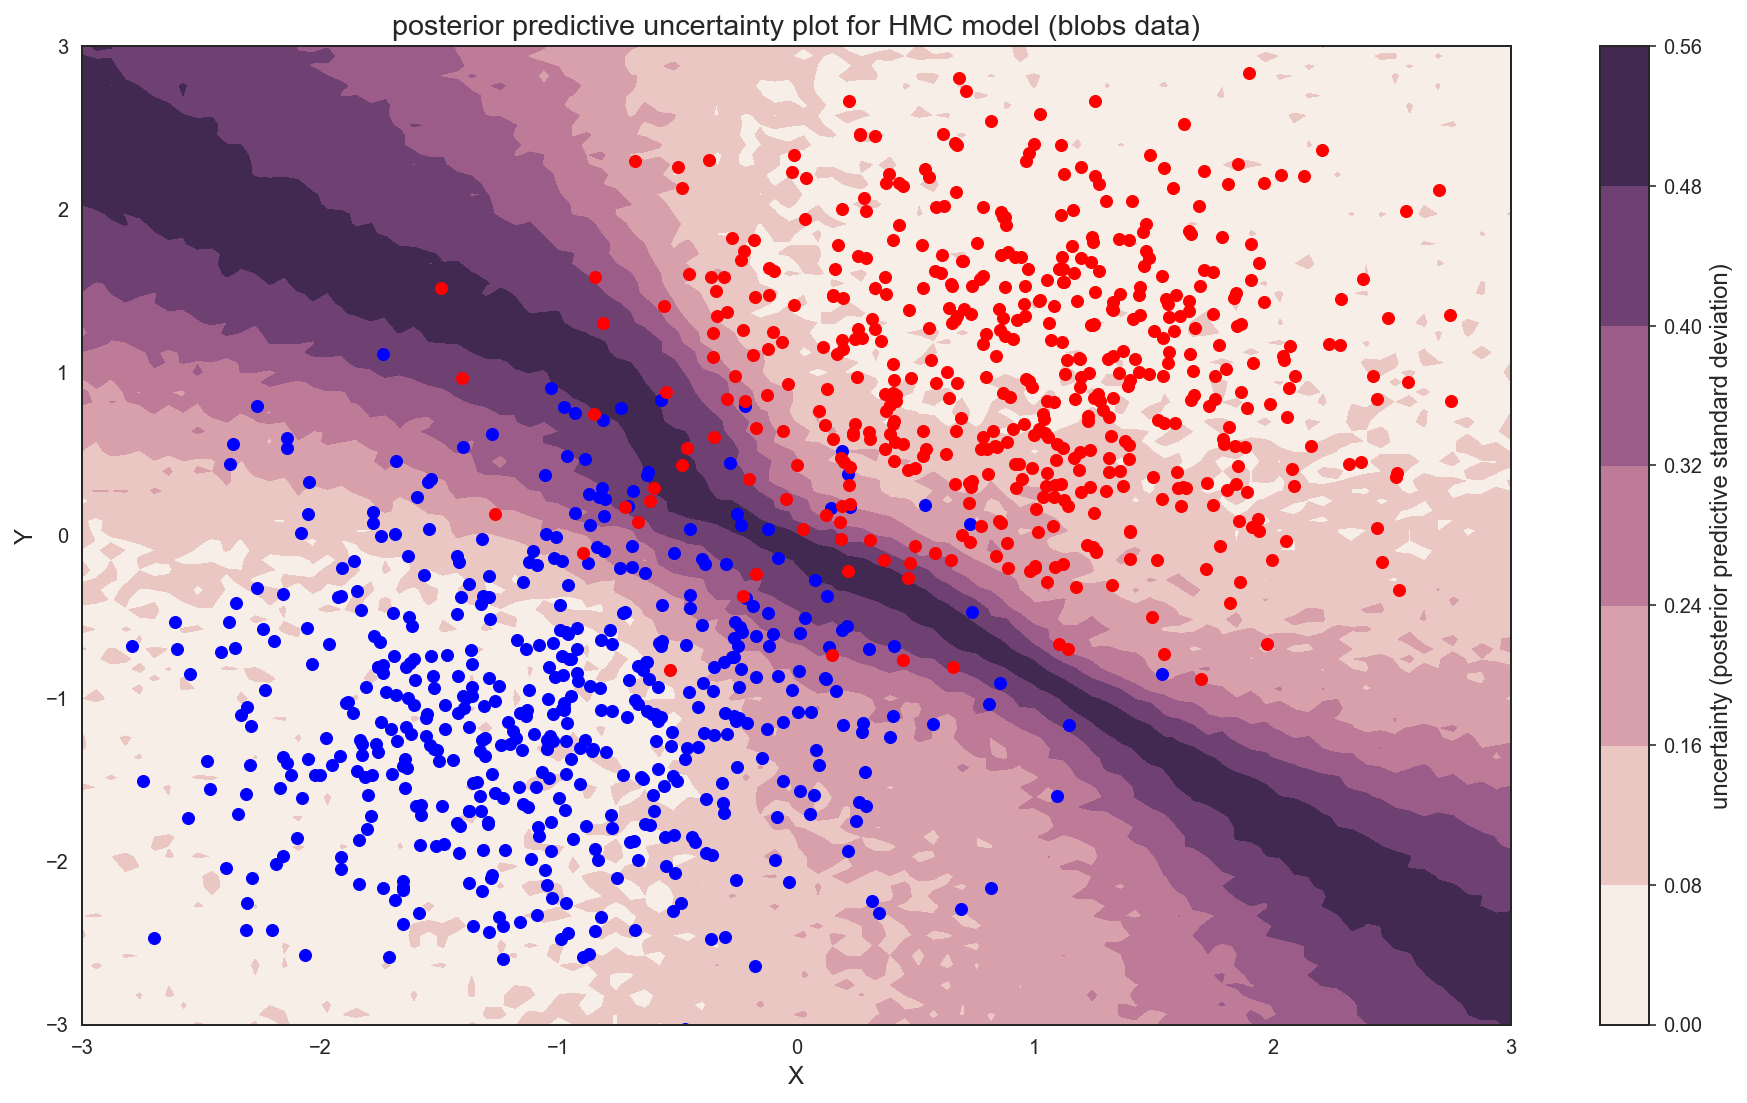

In [70]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc["out"].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive uncertainty plot for HMC model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('uncertainty (posterior predictive standard deviation)')
plt.savefig("{}_uncertainty_plot_hmc.png".format(TOY_DATA_TYPE))

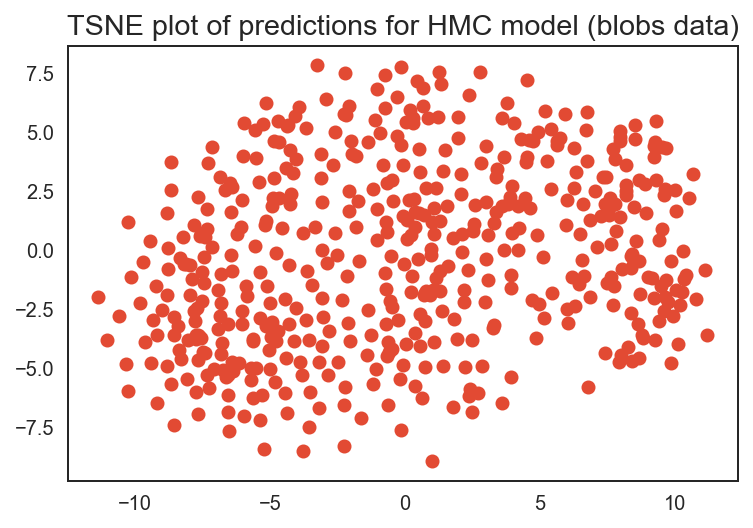

In [71]:
pm.set_data(new_data={'ann_input': grid_2d, 'ann_output': dummy_out}, model=neural_network)
ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)["out"]
tsne = TSNE(n_components=2)
ppc_pca = tsne.fit_transform(ppc)


plt.plot(ppc_pca[:,0], ppc_pca[:,1], linestyle = "", marker = "o")
plt.title("TSNE plot of predictions for HMC model ({} data)".format(TOY_DATA_TYPE))
plt.savefig("{}_tsne_plot_hmc.png".format(TOY_DATA_TYPE))

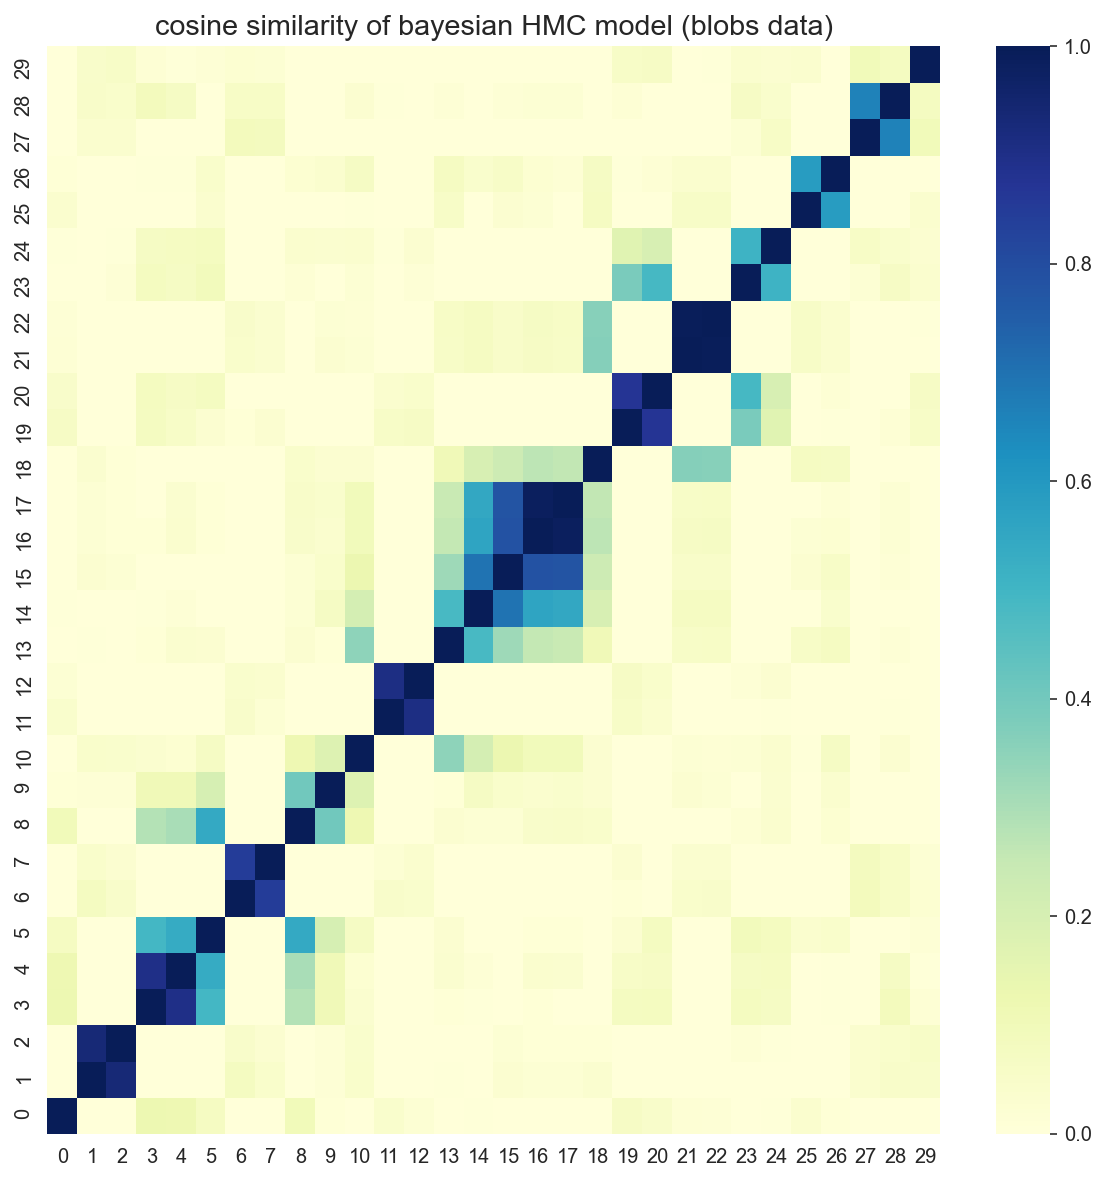

In [72]:
combined = trace["w_in_1"].reshape(-1, 64*2)
combined = np.concatenate((combined, trace["w_1_2"].reshape(-1, 64*8)), axis=1)
combined = np.concatenate((combined, trace["w_2_out"]), axis=1)
combined = np.concatenate((combined, trace["b_in_1"]), axis=1)
combined = np.concatenate((combined, trace["b_1_2"]), axis=1)
combined = np.concatenate((combined, trace["b_3_out"]), axis=1)

df = pd.DataFrame(np.array(combined)[-30:])

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(cosine_similarity(df),vmin=0, vmax=1, cmap="YlGnBu") # vmin=0.9, vmax=1
plt.title("cosine similarity of bayesian HMC model ({} data)".format(TOY_DATA_TYPE))
ax.invert_yaxis()
plt.savefig("{}_cos_similarity_plot_hmc.png".format(TOY_DATA_TYPE))

### ADVI

In [73]:
neural_network = construct_nn(X_train, Y_train)

In [74]:
with neural_network:
    steps = pm.ADVI()
    #use the specify sampler to sample from the posterior of the model
    approx = pm.fit(n=30000, method=steps)

Finished [100%]: Average Loss = 225.32


In [75]:
# create symbolic input
x_sym = T.matrix('X_test')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n_sym = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x_sym.tag.test_value = np.empty_like(X_test)
n_sym.tag.test_value = X_test.shape[1]
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n_sym,
                                   more_replacements={neural_network['ann_input']: x_sym})
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x_sym, n_sym], _sample_proba)
pred = (sample_proba(X_test, 500).mean(0) > 0.5) * 1
print('Test Set Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Test Set Accuracy = 97.3%


In [76]:
ppc = sample_proba(test_points ,500)
ood_variance = np.std(ppc,axis=0)**2

for i in range(len(test_points)):
    print("uncertainty for test point: {} : {}".format(test_points[i], ood_variance[i]))

uncertainty for test point: (-5, -5) : 0.0011065356135061012
uncertainty for test point: (-5, 3.5) : 0.0895818598730396
uncertainty for test point: (5, 5) : 0.0010952104288005902
uncertainty for test point: (5, -3.5) : 0.09228897791005668
uncertainty for test point: (-1, 1) : 0.10002147560359374
uncertainty for test point: (-1, -1.5) : 0.0027124362199062533
uncertainty for test point: (1, 1.5) : 0.000822627887419365


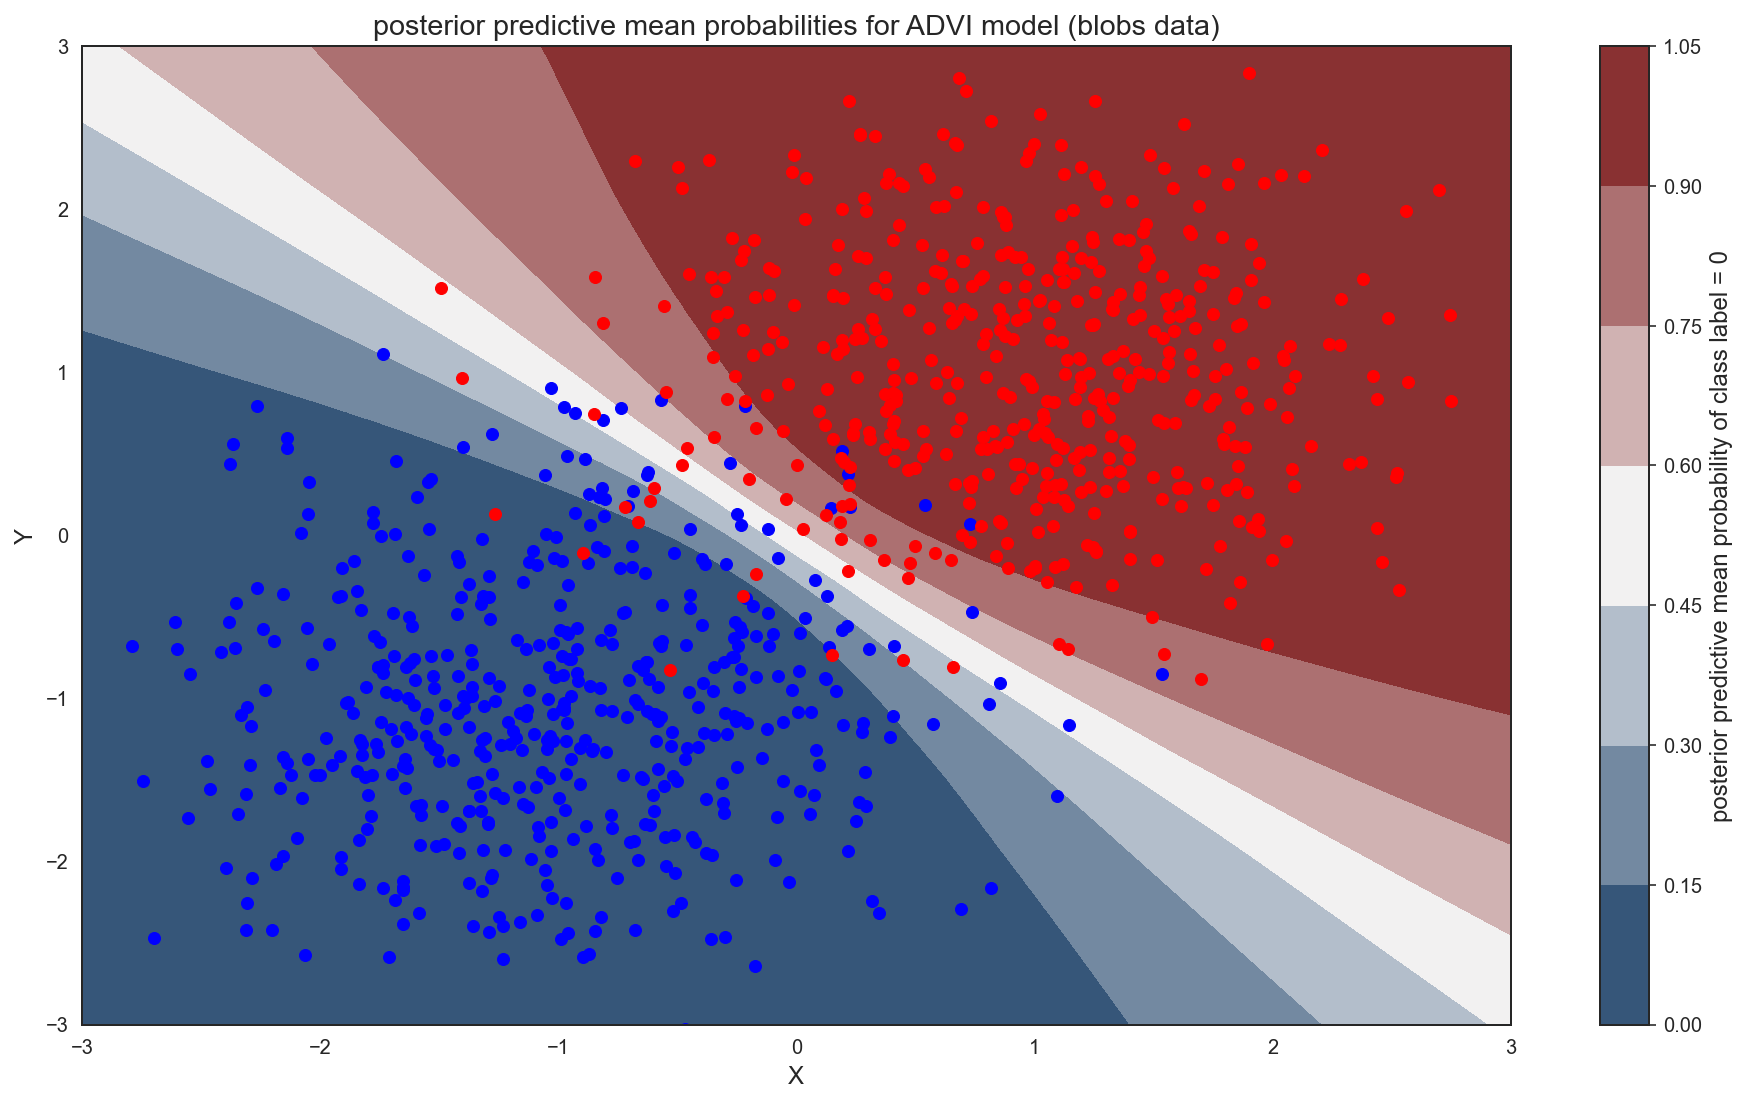

In [77]:
# populate grid with average predictions
ppc = sample_proba(grid_2d ,500)
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive mean probabilities for ADVI model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('posterior predictive mean probability of class label = 0')
plt.savefig("{}_posterior_predictive_plot_advi.png".format(TOY_DATA_TYPE))

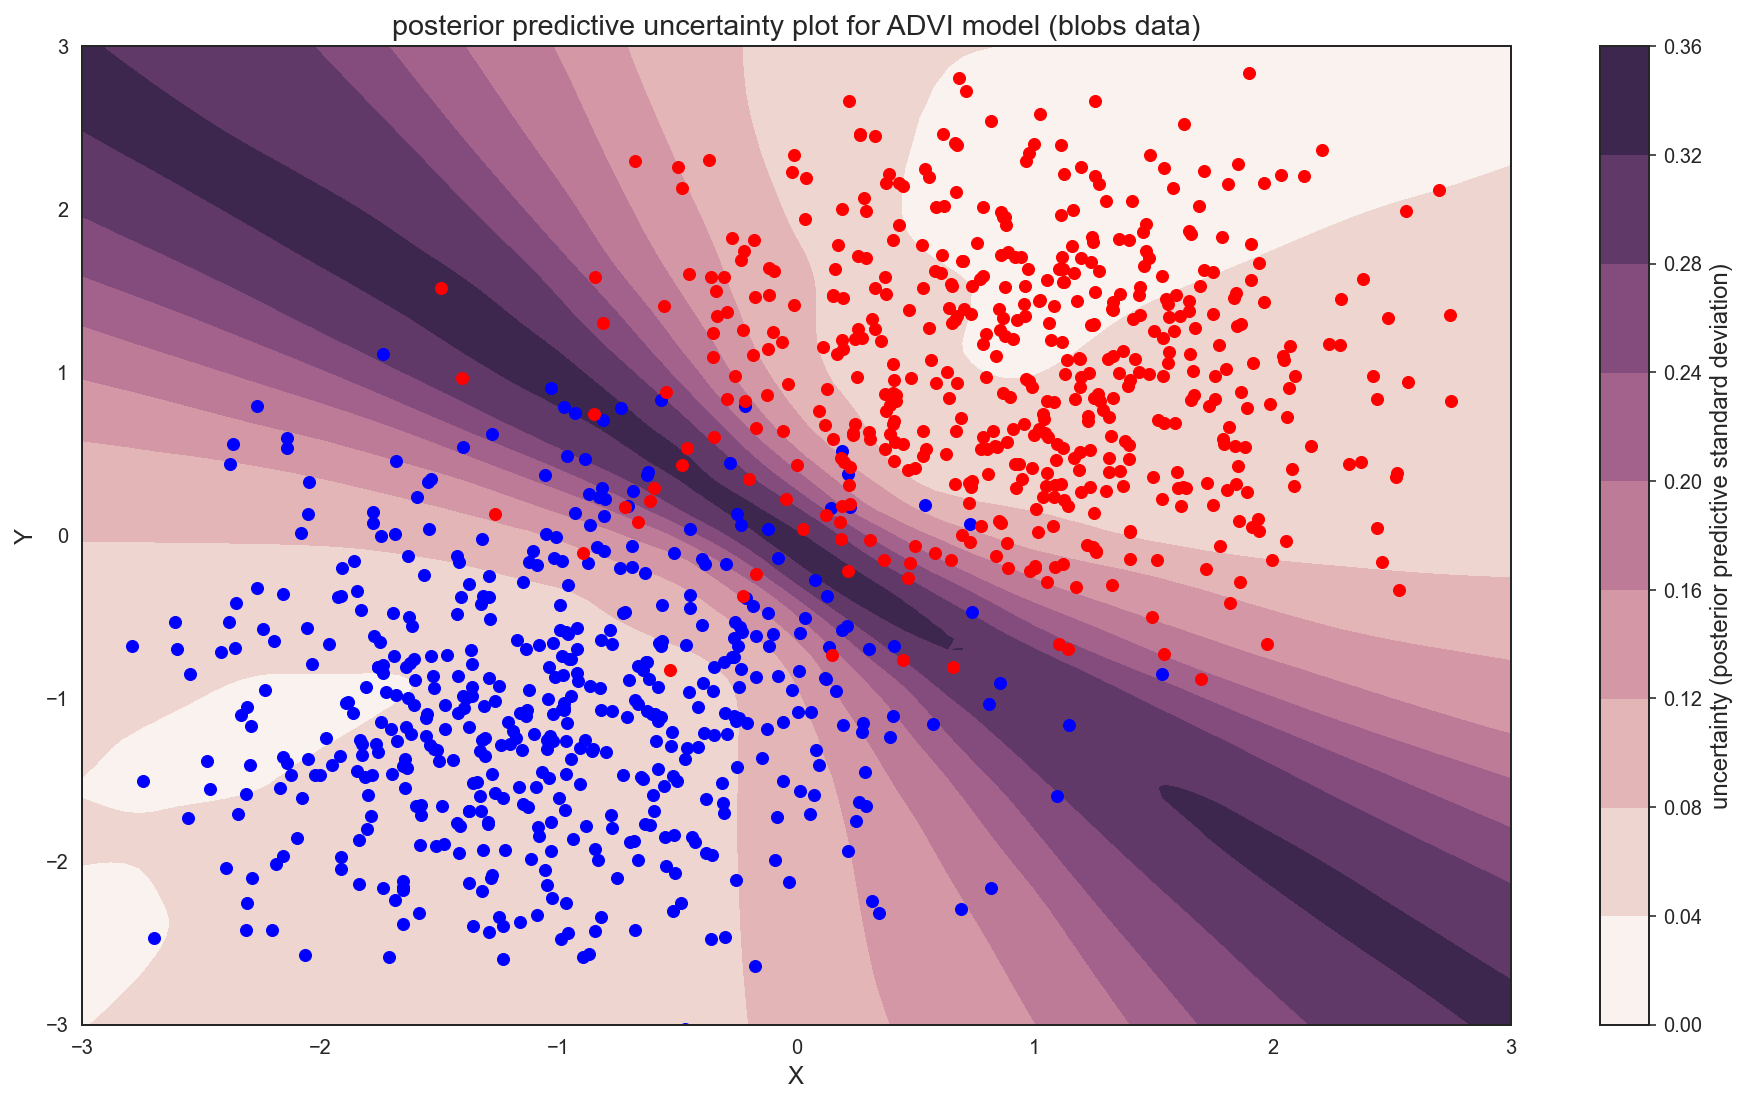

In [78]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive uncertainty plot for ADVI model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('uncertainty (posterior predictive standard deviation)')
plt.savefig("{}_uncertainty_plot_advi.png".format(TOY_DATA_TYPE))

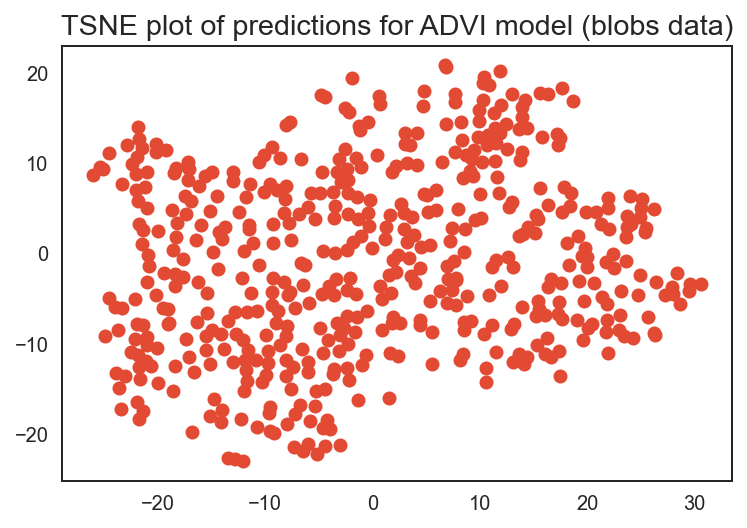

In [79]:
ppc = sample_proba(X_test ,500)
tsne = TSNE(n_components=2)
ppc_pca = tsne.fit_transform(ppc)


plt.plot(ppc_pca[:,0], ppc_pca[:,1], linestyle = "", marker = "o")
plt.title("TSNE plot of predictions for ADVI model ({} data)".format(TOY_DATA_TYPE))
plt.savefig("{}_tsne_plot_advi.png".format(TOY_DATA_TYPE))

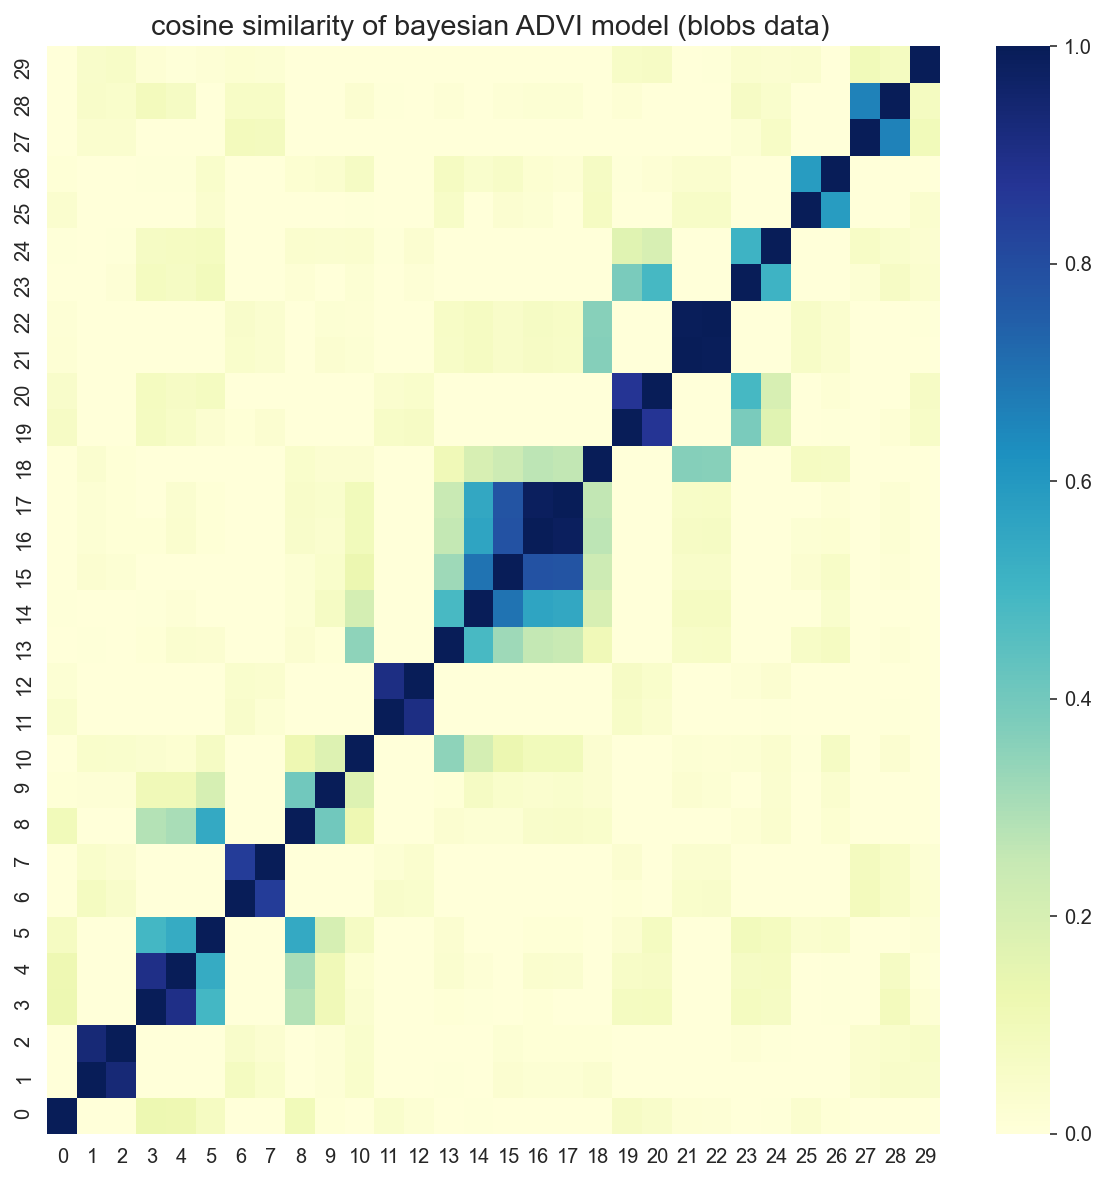

In [80]:
combined = trace["w_in_1"].reshape(-1, 64*2)
combined = np.concatenate((combined, trace["w_1_2"].reshape(-1, 64*8)), axis=1)
combined = np.concatenate((combined, trace["w_2_out"]), axis=1)
combined = np.concatenate((combined, trace["b_in_1"]), axis=1)
combined = np.concatenate((combined, trace["b_1_2"]), axis=1)
combined = np.concatenate((combined, trace["b_3_out"]), axis=1)

df = pd.DataFrame(np.array(combined)[-30:])

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(cosine_similarity(df),vmin=0, vmax=1, cmap="YlGnBu") # vmin=0.9, vmax=1
plt.title("cosine similarity of bayesian ADVI model ({} data) ".format(TOY_DATA_TYPE))
ax.invert_yaxis()
plt.savefig("{}_cosine_similarity_plot_advi.png".format(TOY_DATA_TYPE))